In [2]:
import datetime
from dateutil.parser import parse
import itertools
from itertools import product
import math
import matplotlib.pyplot as plt
from multiprocessing.dummy import Pool as ThreadPool
import nolds
import numpy as np
import os
import pandas as pd
import pathlib
from PreprocessFcns import *
import pywt
import random
import scipy
from scipy.fftpack import fft
from scipy.signal import butter, welch, filtfilt, resample
from scipy.stats import skew, kurtosis, entropy, pearsonr
import seaborn as sns
import sklearn
from sklearn import multiclass
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import LeaveOneGroupOut
import time
%matplotlib inline

In [3]:
# set path to folder containing clinic watch data
path = r'//FS2.smpp.local\\RTO\\CIS-PD Study\MJFF Curation\Finalized Dataset'
# set path to destination folder
dest = r'//FS2.smpp.local\\RTO\\CIS-PD Study\Watch Features Data'
#---------------------------------------------------------------------------------------------------------

In [4]:
VisitNumber = {
    '2 Weeks: Time 0'   : 0,
    '2 Weeks: Time 30'  : 1,
    '2 Weeks: Time 60'  : 2,
    '2 Weeks: Time 90'  : 3,
    '2 Weeks: Time 120' : 4,
    '2 Weeks: Time 150' : 5,
    '1 Month'           : 6
}

ClinicTasks = {
    'Stndg'    : 'Standing',
    'Wlkg'     : 'Walking',
    'WlkgCnt'  : 'Walking while counting',
    'FtnR'     : 'Finger to nose--right hand',
    'FtnL'     : 'Finger to nose--left hand',
    'RamR'     : 'Alternating right hand movements',
    'RamL'     : 'Alternating left hand movements',
    'SitStand' : 'Sit to stand',
    'Drwg'     : 'Drawing on a paper',
    'Typg'     : 'Typing on a computer keyboard',
    'NtsBts'   : 'Assembling nuts and bolts',
    'Drnkg'    : 'Taking a glass of water and drinking',
    'Sheets'   : 'Organizing sheets in a folder',
    'Fldg'     : 'Folding towels',
    'Sitng'    : 'Sitting'
}

In [15]:
## Correlate Task Symp Scors to Mean FFT Power in Freq Ranges
s_time = time.time()

ClipData = pd.read_csv(os.path.join(dest, 'Clinic Data', 'ClinicDataFeaturesX.csv'))[['SubjID', 'Visit', 'TaskAbb', 'Clip', 
                                                                                      'Tremor', 'Bradykinesia', 'Dyskinesia', 
                                                                                      'Overall']]

ClinicFreqData_mean = pd.DataFrame()
ClipFreqData = pd.DataFrame()
for clip in ClipData.iterrows():
    clipacc = pd.read_csv(os.path.join(dest, 'Clinic Data', 'Feature Clips', 
                                       str(int(clip[1]['SubjID'])) + '_' + str(clip[1]['Visit']) + '_' + 
                                       clip[1]['TaskAbb'] + '_' + str(clip[1]['Clip']) + '.csv'), 
                          parse_dates = ['Timestamp'])
    
    clipacc_mag = np.sqrt((clipacc.X)**2 + (clipacc.Y)**2 + (clipacc.Z)**2)
    L = len(clipacc_mag)
    Fs = L / (((pd.to_datetime(clipacc.Timestamp).values.astype(np.int64) // 10**6)[-1] - 
                              (pd.to_datetime(clipacc.Timestamp).values.astype(np.int64) // 10**6)[0]) / 1000)
    P1 = np.abs((fft(clipacc_mag))/L)[:int(L/2 + 1)]
    f = Fs * range(int(L / 2) + 1) / L
    clipFFT = pd.DataFrame()
    clipFFT['f'] = f
    clipFFT['P1'] = P1
    
    ClipFreqData['SubjID'] = [int(clip[1]['SubjID'])]
    ClipFreqData['Visit'] = [clip[1]['Visit']]
    ClipFreqData['TaskAbb'] = [clip[1]['TaskAbb']]
    ClipFreqData['Clip'] = [clip[1]['Clip']]
    ClipFreqData['Tremor'] = [clip[1]['Tremor']]
    ClipFreqData['Bradykinesia'] = [clip[1]['Bradykinesia']]
    ClipFreqData['Dyskinesia'] = [clip[1]['Dyskinesia']]
    ClipFreqData['Overall'] = [clip[1]['Overall']]
    ClipFreqData['0-2'] = [np.mean(clipFFT.P1[(clipFFT.f >= 0) & (clipFFT.f <= 2)])]
    ClipFreqData['2-4'] = [np.mean(clipFFT.P1[(clipFFT.f >= 2) & (clipFFT.f <= 4)])]
    ClipFreqData['4-6'] = [np.mean(clipFFT.P1[(clipFFT.f >= 4) & (clipFFT.f <= 6)])]
    ClipFreqData['4-8'] = [np.mean(clipFFT.P1[(clipFFT.f >= 4) & (clipFFT.f <= 8)])] # thought to be optimal
    ClipFreqData['6-8'] = [np.mean(clipFFT.P1[(clipFFT.f >= 6) & (clipFFT.f <= 8)])]
    ClipFreqData['8-10'] = [np.mean(clipFFT.P1[(clipFFT.f >= 8) & (clipFFT.f <= 10)])]
    ClipFreqData['10-12'] = [np.mean(clipFFT.P1[(clipFFT.f >= 10) & (clipFFT.f <= 12)])]
    ClipFreqData['12-14'] = [np.mean(clipFFT.P1[(clipFFT.f >= 12) & (clipFFT.f <= 14)])]
    ClipFreqData['14-16'] = [np.mean(clipFFT.P1[(clipFFT.f >= 14) & (clipFFT.f <= 16)])]
    ClipFreqData['16-18'] = [np.mean(clipFFT.P1[(clipFFT.f >= 16) & (clipFFT.f <= 18)])]
    ClipFreqData['18-20'] = [np.mean(clipFFT.P1[(clipFFT.f >= 18) & (clipFFT.f <= 20)])]
    
    if ClinicFreqData_mean.empty:
        ClinicFreqData_mean = ClipFreqData
        continue
    ClinicFreqData_mean = pd.concat([ClinicFreqData_mean, ClipFreqData], ignore_index = True)

print(str(int(((time.time() - s_time) / 60) / 60)) + ' hours ' + 
      str(int(((time.time() - s_time) / 60) % 60)) + ' minutes ' + 
      str(int((time.time() - s_time) % 60)) + ' seconds')
    
ClinicFreqData_mean.head()

0 hours 7 minutes 55 seconds


SubjID  Visit TaskAbb  Clip  Tremor  Bradykinesia  Dyskinesia  Overall  \
0    1003      0   Drnkg     1     1.0           1.0         0.0      1.0   
1    1003      0   Drnkg     1     1.0           1.0         0.0      1.0   
2    1003      0   Drnkg     2     1.0           1.0         0.0      1.0   
3    1003      0   Drnkg     3     1.0           1.0         0.0      1.0   
4    1003      0   Drnkg     4     1.0           1.0         0.0      1.0   

        0-2       2-4       4-6       4-8       6-8      8-10     10-12  \
0  0.030181  0.008620  0.007226  0.007266  0.007306  0.005490  0.005086   
1  0.030181  0.008620  0.007226  0.007266  0.007306  0.005490  0.005086   
2  0.032824  0.008381  0.007966  0.007937  0.007908  0.005830  0.005642   
3  0.024240  0.006764  0.005432  0.005050  0.004667  0.003970  0.003728   
4  0.037756  0.011680  0.005614  0.004923  0.004232  0.008367  0.007004   

      12-14     14-16     16-18     18-20  
0  0.002736  0.003237  0.003203  0.002249  
1  0.002736  0.003237  0.003203  0.002249  
2  0.004866  0.004162  0.003185  0.002971  
3  0.004505  0.003290  0.001984  0.002305  
4  0.006020  0.002725  0.002686  0.001972

In [13]:
## Correlate Task Symp Scors to MAX FFT Power in Freq Ranges
s_time = time.time()

ClipData = pd.read_csv(os.path.join(dest, 'Clinic Data', 'ClinicDataFeaturesX.csv'))[['SubjID', 'Visit', 'TaskAbb', 'Clip', 
                                                                                      'Tremor', 'Bradykinesia', 'Dyskinesia', 
                                                                                      'Overall']]

ClinicFreqData_max = pd.DataFrame()
ClipFreqData = pd.DataFrame()
for clip in ClipData.iterrows():
    clipacc = pd.read_csv(os.path.join(dest, 'Clinic Data', 'Feature Clips', 
                                       str(int(clip[1]['SubjID'])) + '_' + str(clip[1]['Visit']) + '_' + 
                                       clip[1]['TaskAbb'] + '_' + str(clip[1]['Clip']) + '.csv'), 
                          parse_dates = ['Timestamp'])
    
    clipacc_mag = np.sqrt((clipacc.X)**2 + (clipacc.Y)**2 + (clipacc.Z)**2)
    L = len(clipacc_mag)
    Fs = L / (((pd.to_datetime(clipacc.Timestamp).values.astype(np.int64) // 10**6)[-1] - 
                              (pd.to_datetime(clipacc.Timestamp).values.astype(np.int64) // 10**6)[0]) / 1000)
    P1 = np.abs((fft(clipacc_mag))/L)[:int(L/2 + 1)]
    f = Fs * range(int(L / 2) + 1) / L
    clipFFT = pd.DataFrame()
    clipFFT['f'] = f
    clipFFT['P1'] = P1
    
    ClipFreqData['SubjID'] = [int(clip[1]['SubjID'])]
    ClipFreqData['Visit'] = [clip[1]['Visit']]
    ClipFreqData['TaskAbb'] = [clip[1]['TaskAbb']]
    ClipFreqData['Clip'] = [clip[1]['Clip']]
    ClipFreqData['Tremor'] = [clip[1]['Tremor']]
    ClipFreqData['Bradykinesia'] = [clip[1]['Bradykinesia']]
    ClipFreqData['Dyskinesia'] = [clip[1]['Dyskinesia']]
    ClipFreqData['Overall'] = [clip[1]['Overall']]
    ClipFreqData['0-2'] = [np.max(clipFFT.P1[(clipFFT.f >= 0) & (clipFFT.f <= 2)])]
    ClipFreqData['2-4'] = [np.max(clipFFT.P1[(clipFFT.f >= 2) & (clipFFT.f <= 4)])]
    ClipFreqData['4-6'] = [np.max(clipFFT.P1[(clipFFT.f >= 4) & (clipFFT.f <= 6)])]
    ClipFreqData['4-8'] = [np.max(clipFFT.P1[(clipFFT.f >= 4) & (clipFFT.f <= 8)])] # thought to be optimal
    ClipFreqData['6-8'] = [np.max(clipFFT.P1[(clipFFT.f >= 6) & (clipFFT.f <= 8)])]
    ClipFreqData['8-10'] = [np.max(clipFFT.P1[(clipFFT.f >= 8) & (clipFFT.f <= 10)])]
    ClipFreqData['10-12'] = [np.max(clipFFT.P1[(clipFFT.f >= 10) & (clipFFT.f <= 12)])]
    ClipFreqData['12-14'] = [np.max(clipFFT.P1[(clipFFT.f >= 12) & (clipFFT.f <= 14)])]
    ClipFreqData['14-16'] = [np.max(clipFFT.P1[(clipFFT.f >= 14) & (clipFFT.f <= 16)])]
    ClipFreqData['16-18'] = [np.max(clipFFT.P1[(clipFFT.f >= 16) & (clipFFT.f <= 18)])]
    ClipFreqData['18-20'] = [np.max(clipFFT.P1[(clipFFT.f >= 18) & (clipFFT.f <= 20)])]
    
    if ClinicFreqData_max.empty:
        ClinicFreqData_max = ClipFreqData
        continue
    ClinicFreqData_max = pd.concat([ClinicFreqData_max, ClipFreqData], ignore_index = True)

print(str(int(((time.time() - s_time) / 60) / 60)) + ' hours ' + 
      str(int(((time.time() - s_time) / 60) % 60)) + ' minutes ' + 
      str(int((time.time() - s_time) % 60)) + ' seconds')
    
ClinicFreqData_max.head()

0 hours 8 minutes 25 seconds


SubjID  Visit TaskAbb  Clip  Tremor  Bradykinesia  Dyskinesia  Overall  \
0    1003      0   Drnkg     1     1.0           1.0         0.0      1.0   
1    1003      0   Drnkg     1     1.0           1.0         0.0      1.0   
2    1003      0   Drnkg     2     1.0           1.0         0.0      1.0   
3    1003      0   Drnkg     3     1.0           1.0         0.0      1.0   
4    1003      0   Drnkg     4     1.0           1.0         0.0      1.0   

        0-2       2-4       4-6       4-8       6-8      8-10     10-12  \
0  0.131847  0.011691  0.013602  0.013602  0.010502  0.009306  0.008956   
1  0.131847  0.011691  0.013602  0.013602  0.010502  0.009306  0.008956   
2  0.157140  0.015378  0.018257  0.018257  0.013690  0.013371  0.009405   
3  0.123707  0.009704  0.009182  0.009182  0.008271  0.007564  0.005658   
4  0.209682  0.026287  0.012307  0.012307  0.010913  0.015509  0.012401   

      12-14     14-16     16-18     18-20  
0  0.004913  0.005042  0.005160  0.002996  
1  0.004913  0.005042  0.005160  0.002996  
2  0.010811  0.006890  0.005946  0.005097  
3  0.007735  0.005792  0.004787  0.003856  
4  0.010009  0.004846  0.004189  0.003324

In [100]:
def scoreTremFFT(FFTmetadata, task, freq, display):
    # FFTmetadata: clip-specific data of FFT powers (generated above) in freq ranges
    # task: Sitng or Stndg
    # freq: 0-2, 2-4, 4-6, 4-8, 6-8, 8-10, 10-12, 12-14, 14-16, 16-18, 18-20; 4-8 thought to be optimal
    # display: True or False
    
    pd.options.mode.chained_assignment = None # prevent warning output for SettingWithCopyWarning
    
    if display:
        print('___________________________________________________________________________')
        print(ClinicTasks[task])

    # isolate FFT data corresponding to task of interest
    CombTaskFreq = FFTmetadata[(FFTmetadata.TaskAbb == task)]

    # generate and plot ROC using power in provided freq range as 'prediction'
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(CombTaskFreq.Tremor.apply(lambda x: 1 if x > 0 else x).values, 
                                                     CombTaskFreq[freq].values) # must turn scores to bool for ROC
    if display:
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate', fontsize = 12)
        plt.ylabel('True Positive Rate', fontsize = 12)
        plt.title('ROC Curve Power ' + freq + ' Hz', fontsize = 15)
        plt.show()

    # use the 'ideal' point of ROC to determine threshold power value in range for tremor determination
    ROCTremFFT = pd.DataFrame()
    ROCTremFFT['fpr'] = fpr
    ROCTremFFT['tpr'] = tpr
    ROCTremFFT['thresholds'] = thresholds
    ROCTremFFT['dist01'] = np.sqrt((1-ROCTremFFT.tpr)**2 + ROCTremFFT.fpr**2)
    TremPowerThreshold = ROCTremFFT.thresholds[ROCTremFFT.dist01 == min(ROCTremFFT.dist01)].values
    CombTaskFreq['FFTscore'] = CombTaskFreq[freq].apply(lambda x: 1 if x > float(TremPowerThreshold) else 0)
    CombTaskFreq = CombTaskFreq[['SubjID', 'Visit', 'TaskAbb', 'Clip', 
                                   'Tremor', 'FFTscore', freq]]
    
    # get and consolidate the condensed (by task - not clips) clinic metadata for correlation
    clinicpath = r'//FS2.smpp.local\\RTO\\CIS-PD Study\MJFF Curation\Finalized Dataset'
    clinicData = pd.read_csv(os.path.join(clinicpath, 'Metadata Tables', 'Table4.csv'))
    clinicTask = clinicData[(clinicData.TaskAbb == task)]
    TaskClinicData = pd.DataFrame()
    TaskData = pd.DataFrame()
    for task in clinicTask.iterrows():
        file = str(int(task[1]['SubjID'])) + '_' + str(VisitNumber[task[1]['Visit']]) + '_' + task[1]['TaskAbb']
        TaskData['SubjID'] = [int(task[1]['SubjID'])]
        TaskData['Visit'] = [VisitNumber[task[1]['Visit']]]
        TaskData['TaskAbb'] = [task[1]['TaskAbb']]
        if not type(task[1]['Side']) == str:
            continue
        TaskData['Tremor'] = [task[1]['Tremor - ' + task[1]['Side']]]
        if TaskClinicData.empty:
            TaskClinicData = TaskData
            continue
        TaskClinicData = pd.concat([TaskClinicData, TaskData], ignore_index = True)
        
    # score each task in Table 4 by the ratio of clips scored for tremor with total clips for that task
    ThresholdPred = pd.DataFrame()
    TaskPred = pd.DataFrame()
    for score in TaskClinicData.iterrows():
        totClips = len(CombTaskFreq[(CombTaskFreq.SubjID == score[1]['SubjID']) & 
                                     (CombTaskFreq.Visit == score[1]['Visit'])])
        if totClips == 0: # some of the metadata from Table 4 does not have acc clips associated
            continue
        TremFreqClips = len(CombTaskFreq[(CombTaskFreq.SubjID == score[1]['SubjID']) & 
                                         (CombTaskFreq.Visit == score[1]['Visit']) & 
                                         (CombTaskFreq.FFTscore == 1)])
        TaskPred['SubjID'] = [score[1]['SubjID']]
        TaskPred['Visit'] = [score[1]['Visit']]
        TaskPred['TaskAbb'] = [score[1]['TaskAbb']]
        TaskPred['Tremor'] = [int(score[1]['Tremor'])]
        TaskPred['FFTscoreRatio'] = [TremFreqClips / totClips]
        if ThresholdPred.empty:
            ThresholdPred = TaskPred
            continue
        ThresholdPred = pd.concat([ThresholdPred, TaskPred], ignore_index = True)

    # generate and plot ROC using ratio of power-predicted tremor clips to total clips as 'prediction'
    if display:
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(ThresholdPred.Tremor.apply(lambda x: 1 if x > 0 else x).values,
                                                         ThresholdPred.FFTscoreRatio.values)
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate', fontsize = 12)
        plt.ylabel('True Positive Rate', fontsize = 12)
        plt.title('ROC Curve Threshold Scores', fontsize = 15)
        plt.show()
    
    #provide AUC of Threshold-predicted ratio tremor prediction for comparison
    RatioAUC = sklearn.metrics.roc_auc_score(ThresholdPred.Tremor.apply(lambda x: 1 if x > 0 else x).values,
                                                         ThresholdPred.FFTscoreRatio.values)
    if display:
        print(freq + ' Hz AUC')
        print(RatioAUC)
        print('___________________________________________________________________________')
    
    # CombTaskFreq includes bool prediction for presence/absence of tremor by clip
    # ThresholdPred contains ratio of tremor pred clips to total clips for each task with attached acc data
    # RatioAUC is the AUC value for ROC curve generated using the ratio of predicted trem clips to total clips
    return CombTaskFreq, ThresholdPred, RatioAUC

___________________________________________________________________________
Standing


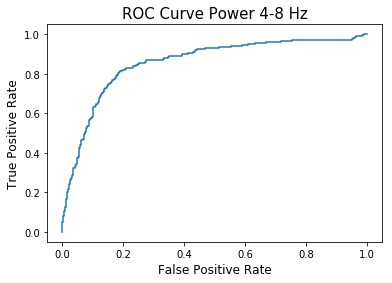

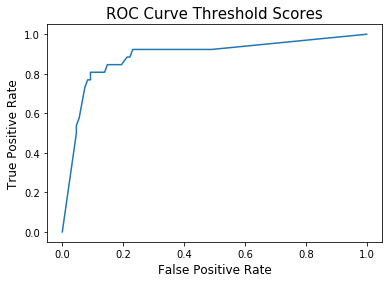

4-8 Hz AUC
0.8887108262108263
___________________________________________________________________________
___________________________________________________________________________
Sitting


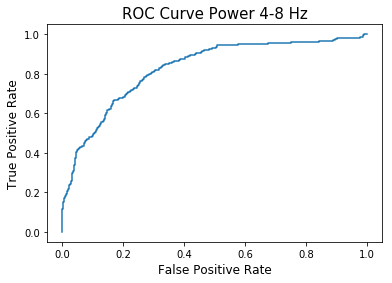

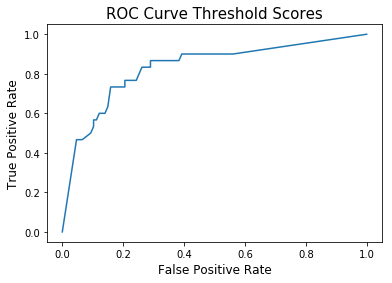

4-8 Hz AUC
0.8313084112149531
___________________________________________________________________________


In [101]:
StndgClipFreq, StndgTaskPred, StndgAUC = scoreTremFFT(ClinicFreqData_max, 'Stndg', '4-8', True)
SitngClipFreq, SitngTaskPred, SitngAUC = scoreTremFFT(ClinicFreqData_max, 'Sitng', '4-8', True)

In [146]:
# filter DataFeatures file to remove clips with disagreement in scores
ClipDataFeatures = pd.read_csv(os.path.join(dest, 'Clinic Data', 'ClinicDataFeaturesX.csv'))
print(len(ClipDataFeatures[(ClipDataFeatures.TaskAbb == 'Sitng') | (ClipDataFeatures.TaskAbb == 'Stndg')]))
confusedClipIdx = ((StndgClipFreq.Tremor.apply(lambda x: 1 if x > 0 else x) != StndgClipFreq.FFTscore))
for clip in confusedClipIdx.index:
    if confusedClipIdx[clip]:
        ClipDataFeatures = ClipDataFeatures.drop([clip])
confusedClipIdx = ((SitngClipFreq.Tremor.apply(lambda x: 1 if x > 0 else x) != SitngClipFreq.FFTscore))
for clip in confusedClipIdx.index:
    if confusedClipIdx[clip]:
        ClipDataFeatures = ClipDataFeatures.drop([clip])
print(len(ClipDataFeatures[(ClipDataFeatures.TaskAbb == 'Sitng') | (ClipDataFeatures.TaskAbb == 'Stndg')]))
# ClipDataFeatures.to_csv(os.path.join(dest, 'Clinic Data', 'ClinicDataFeaturesX_FFTscoreFilt.csv'), index = False)

3053
2365


In [78]:
# determine performance using the different frequency ranges via AUC - Standing
FreqRange = []
AUC = []
for freq in ClinicFreqData_max.columns[8:]:
    StndgClipFreq, StndgTaskPred, StndgAUC = scoreTremFFT(ClinicFreqData_max, 'Stndg', freq, False)
    FreqRange = FreqRange + [freq]
    AUC = AUC + [StndgAUC]
pd.DataFrame({'FreqRange': FreqRange, 'AUC': AUC})

FreqRange       AUC
0        0-2  0.886218
1        2-4  0.849181
2        4-6  0.860399
3        4-8  0.888711
4        6-8  0.891560
5       8-10  0.895833
6      10-12  0.892450
7      12-14  0.893519
8      14-16  0.900107
9      16-18  0.915954
10     18-20  0.876959

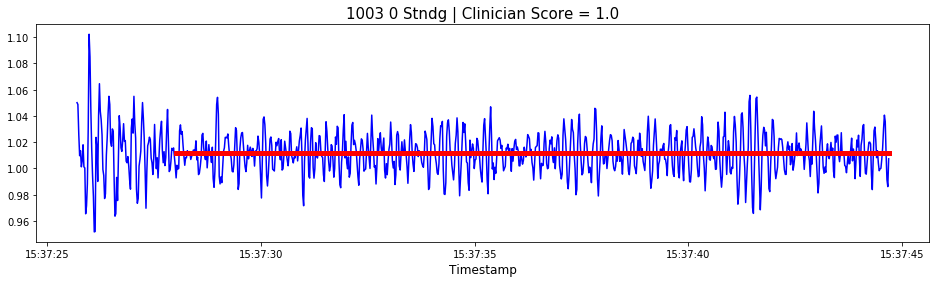

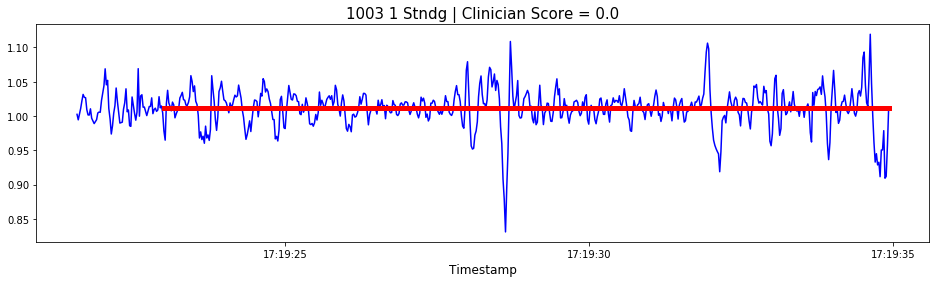

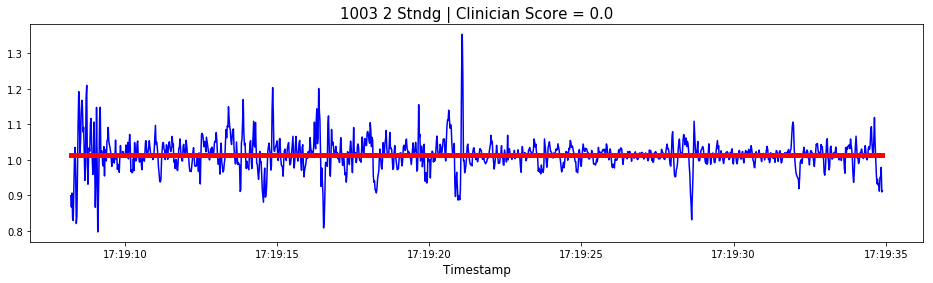

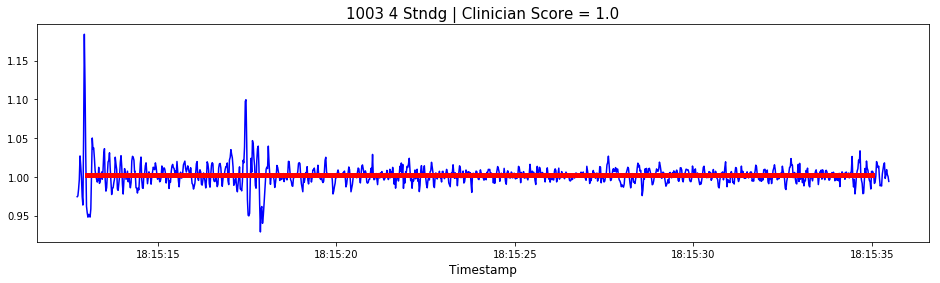

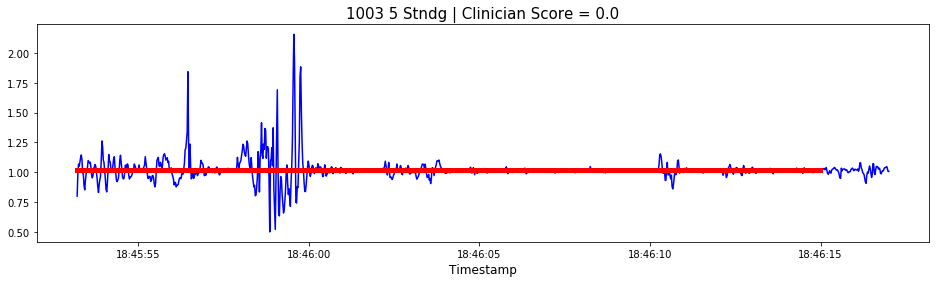

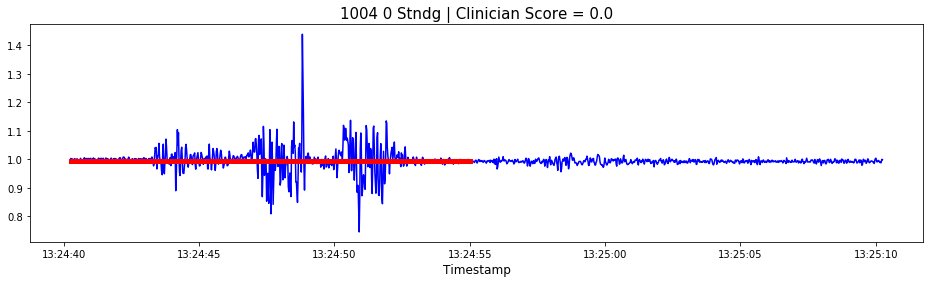

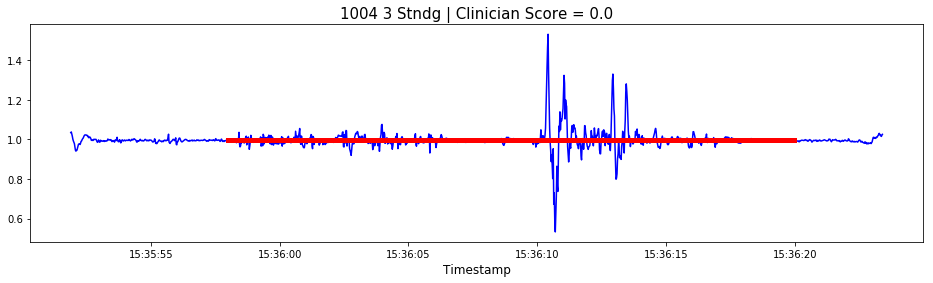

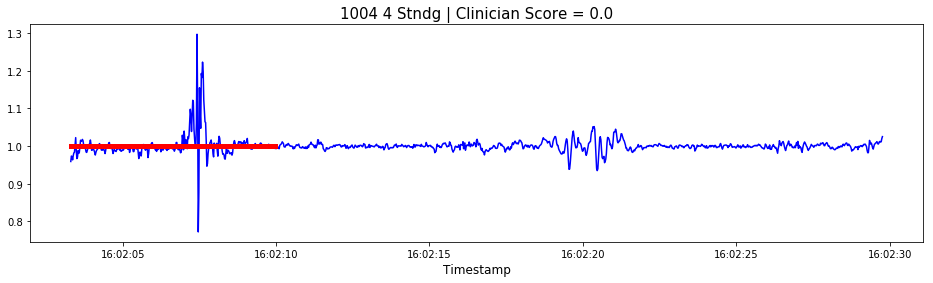

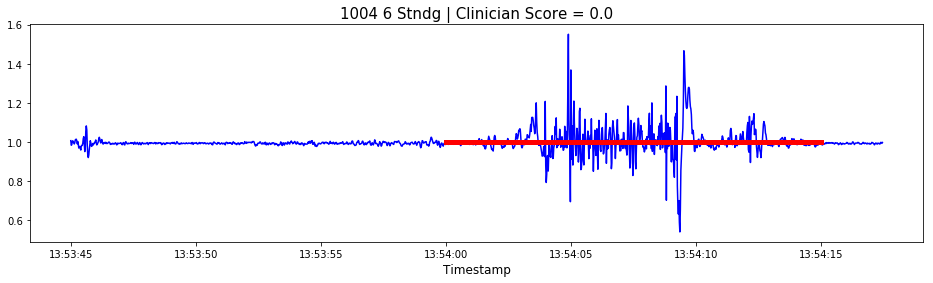

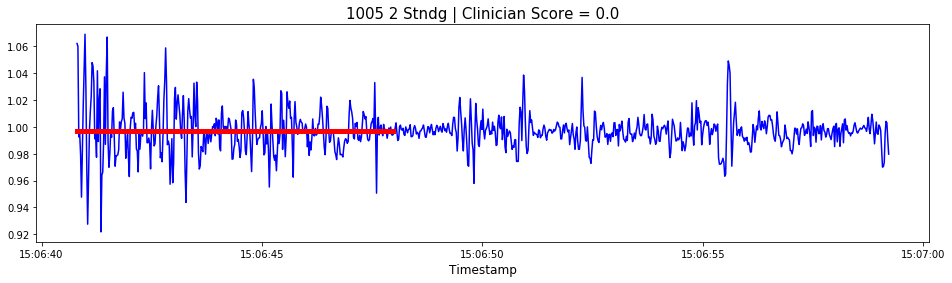

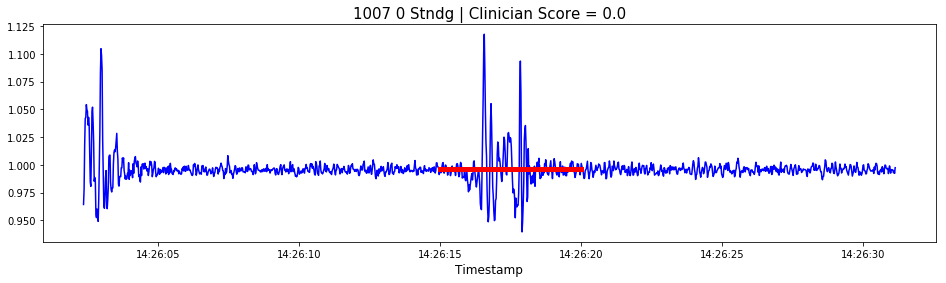

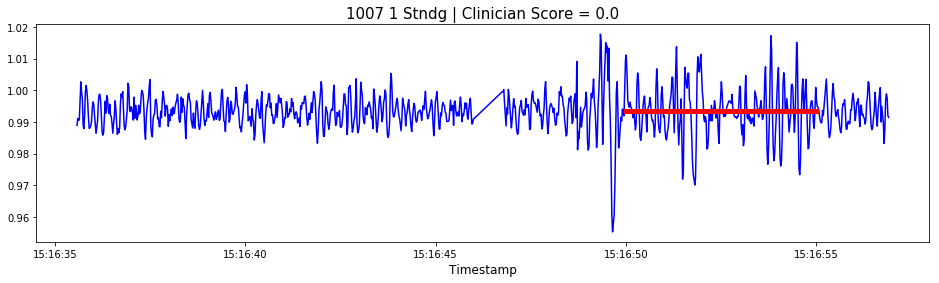

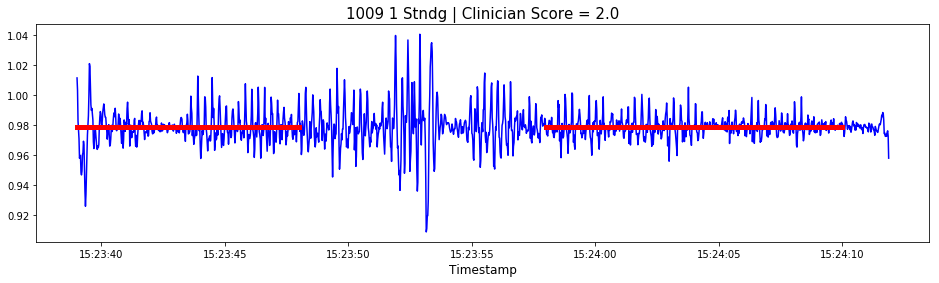

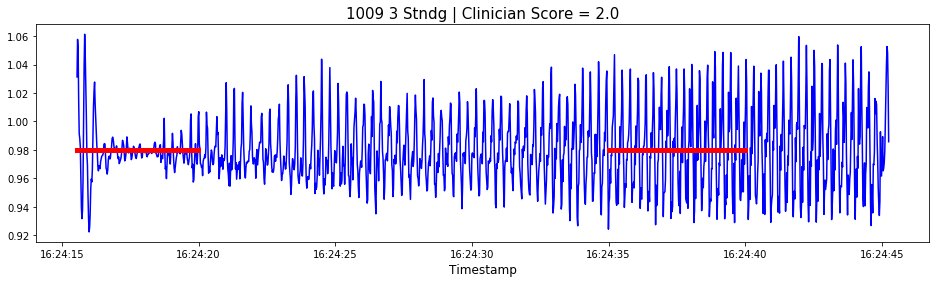

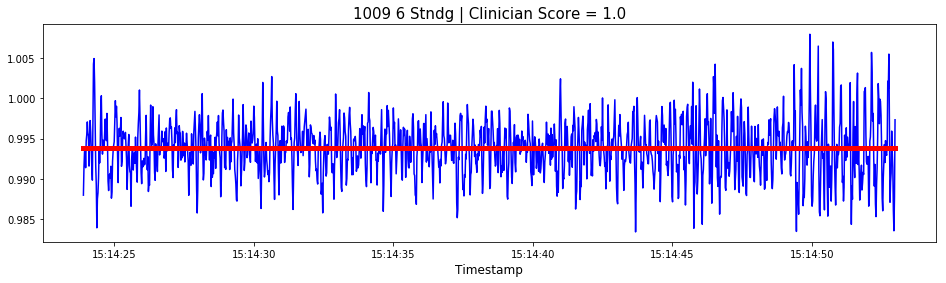

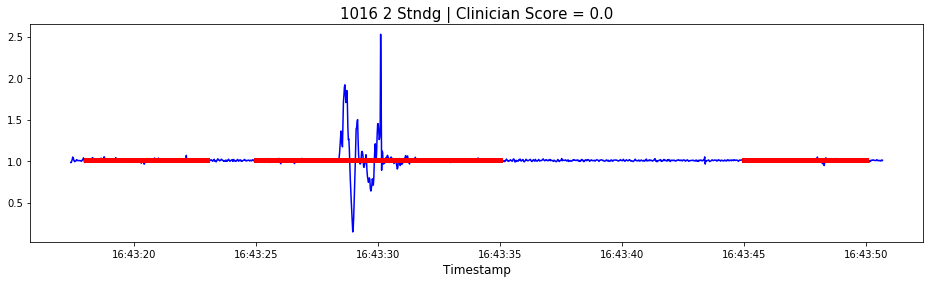

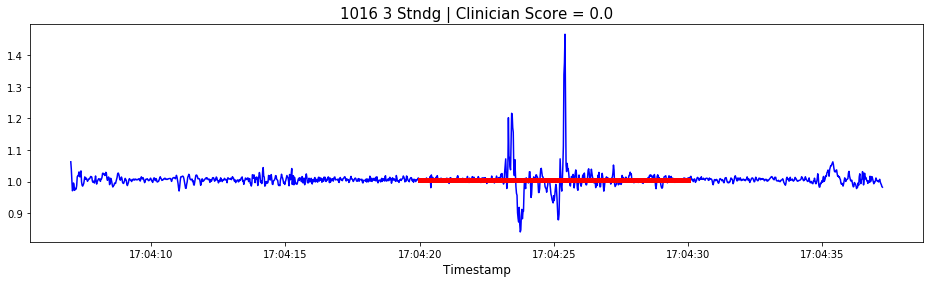

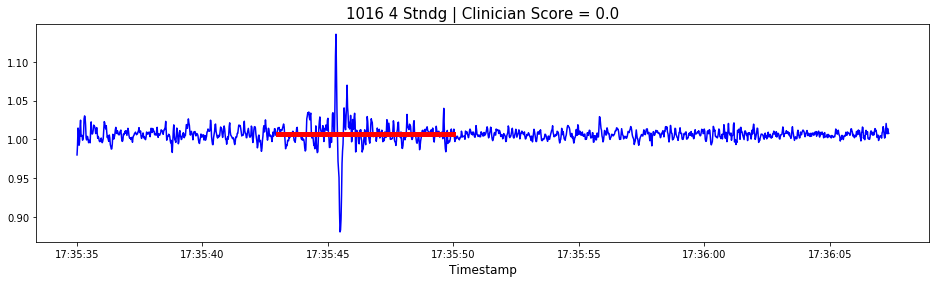

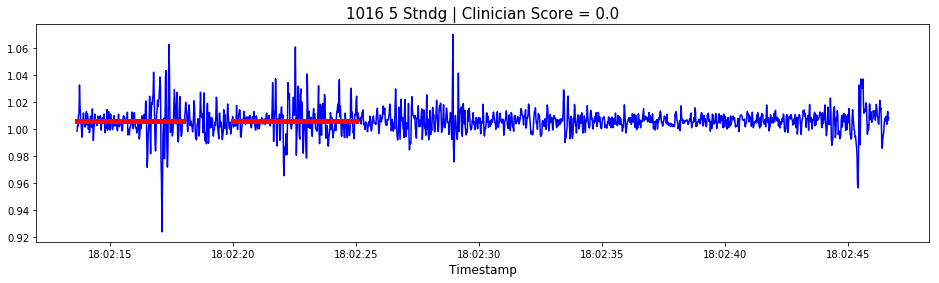

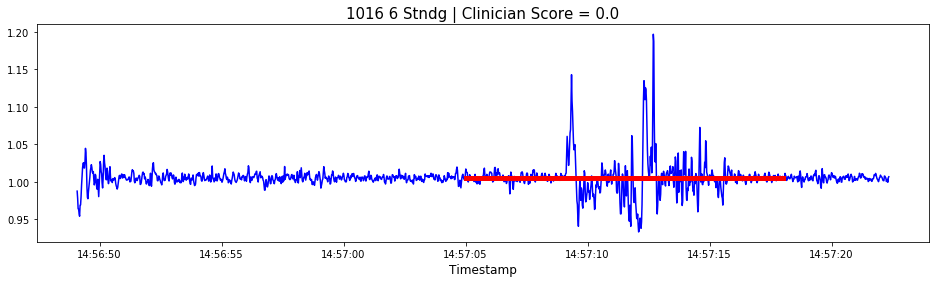

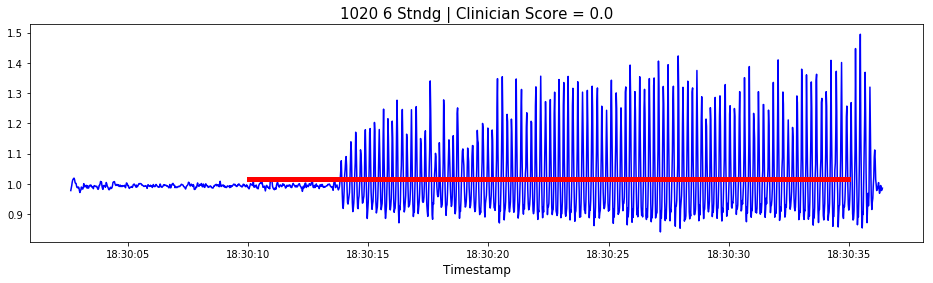

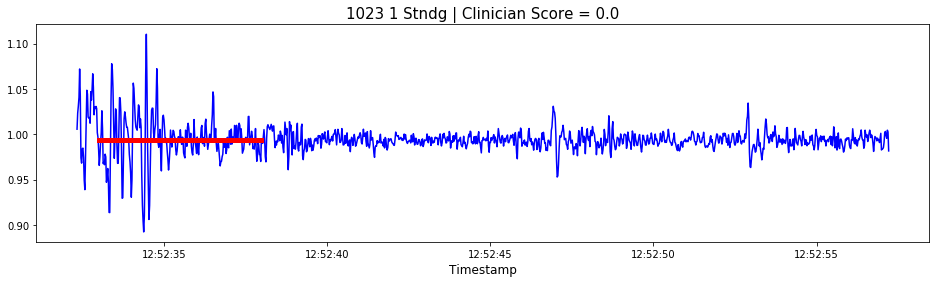

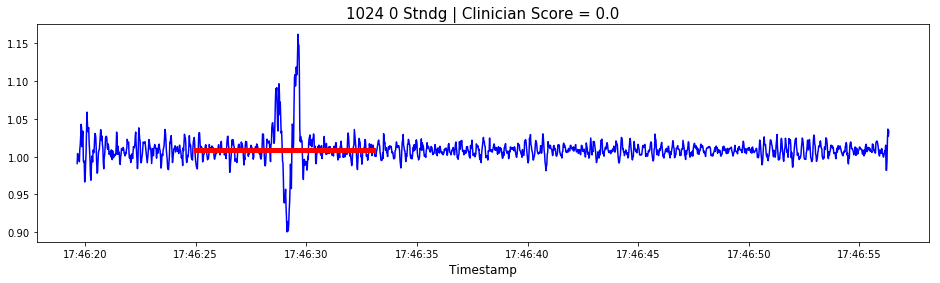

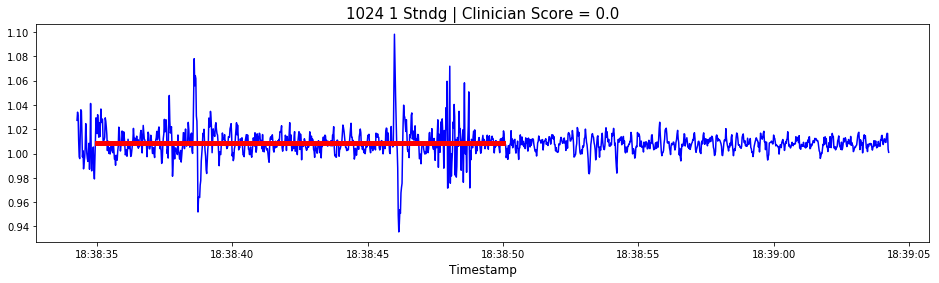

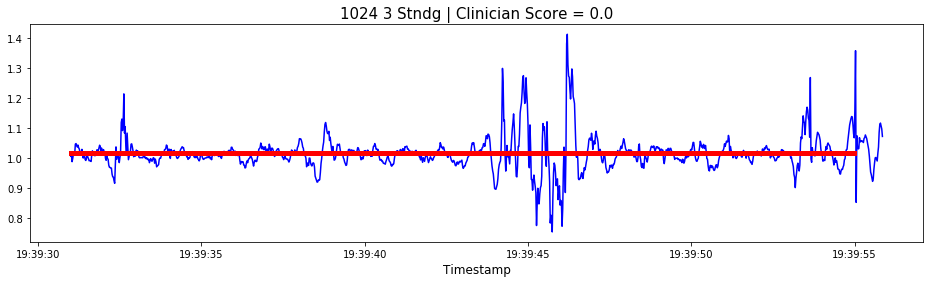

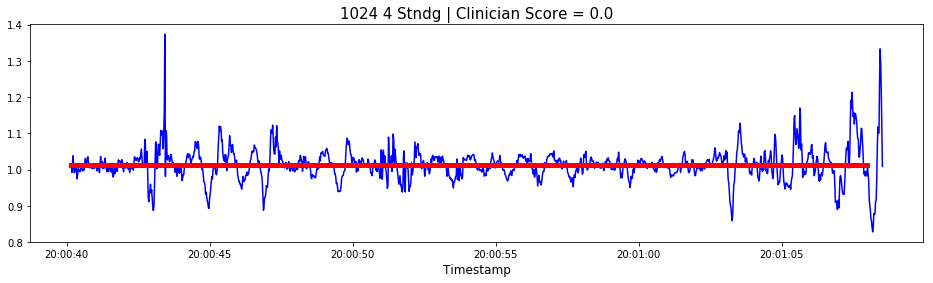

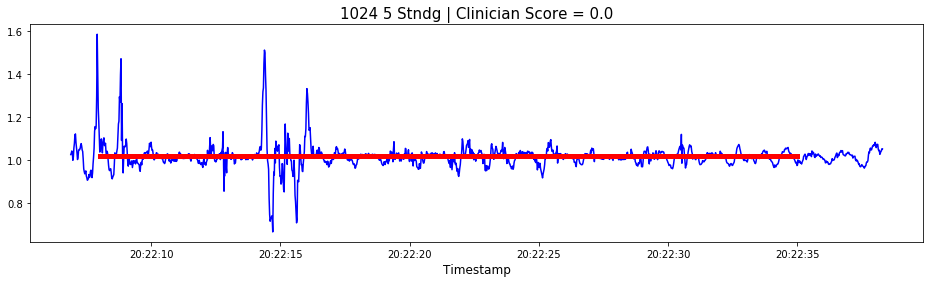

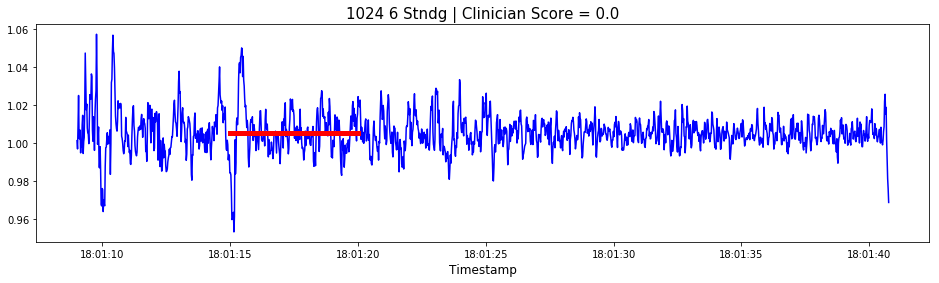

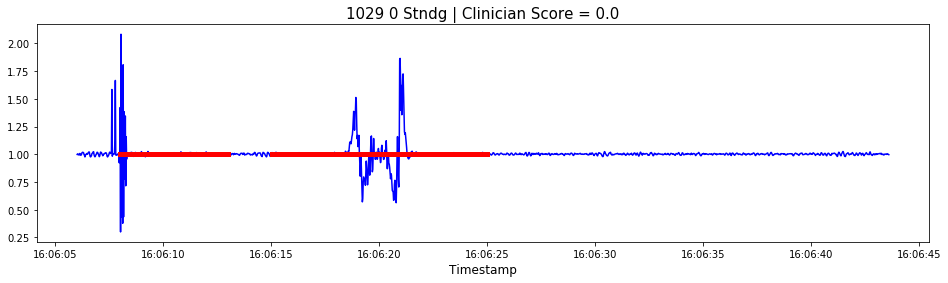

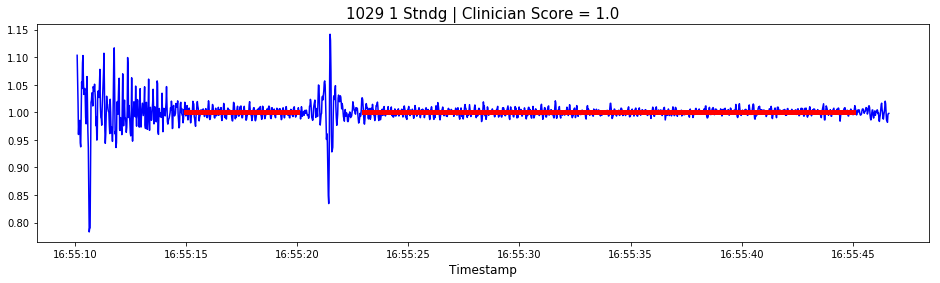

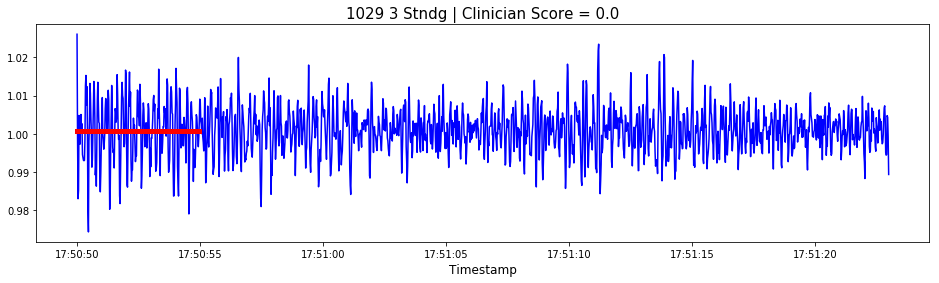

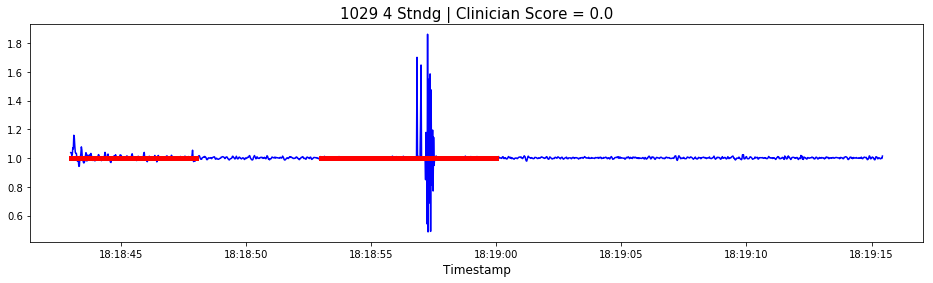

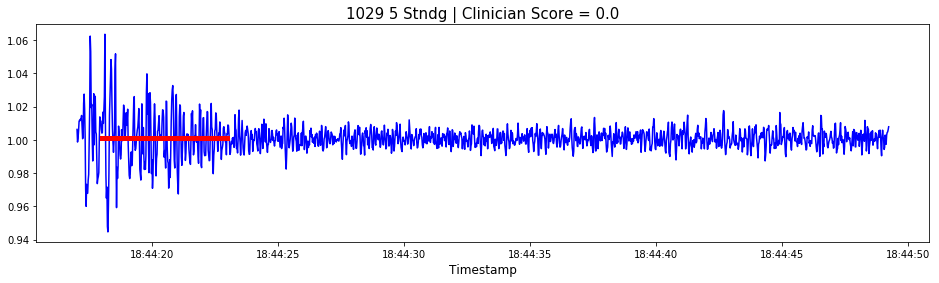

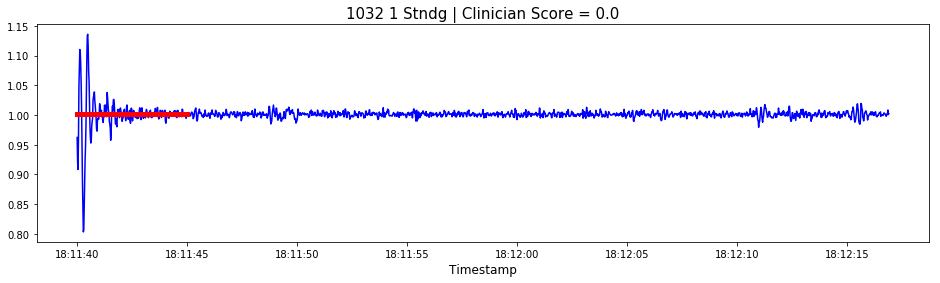

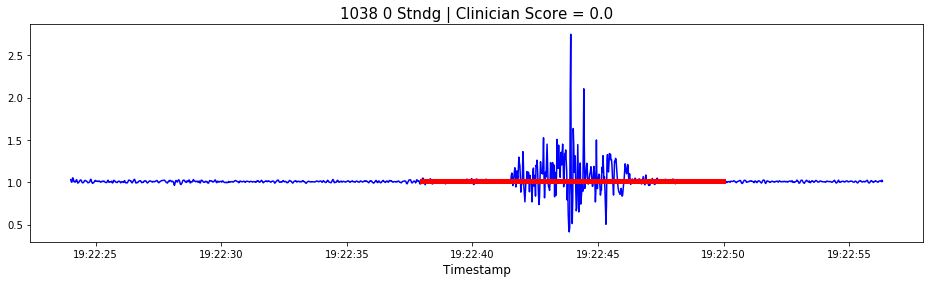

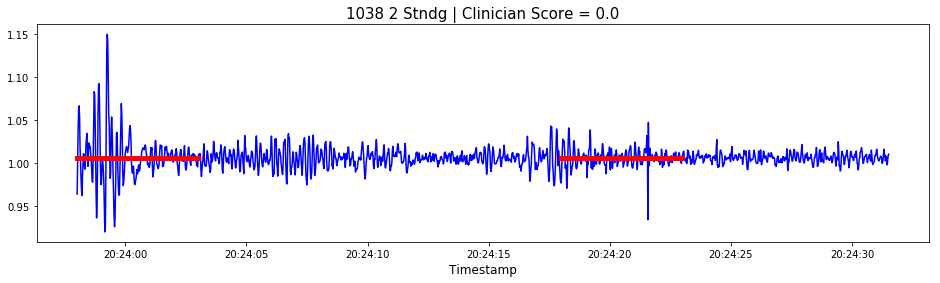

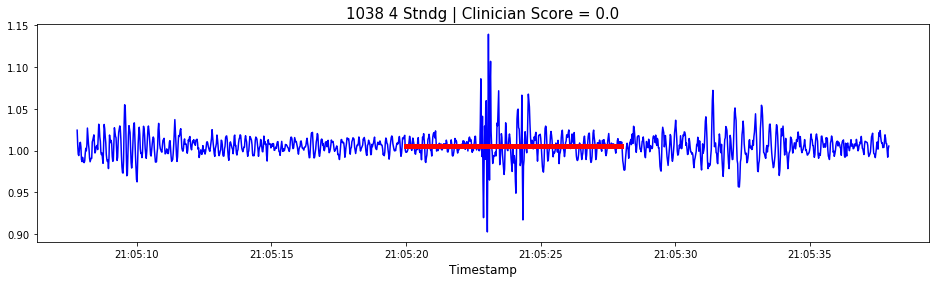

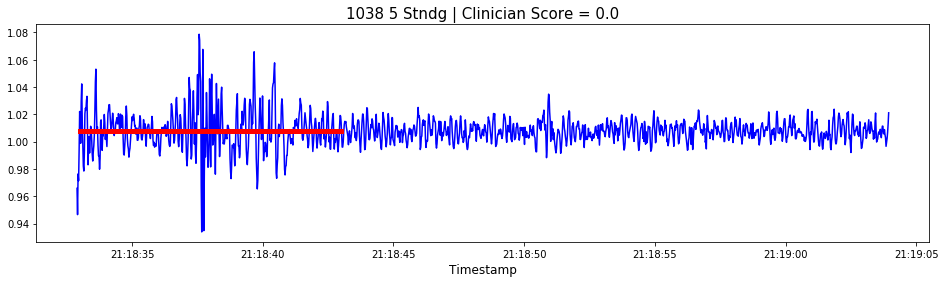

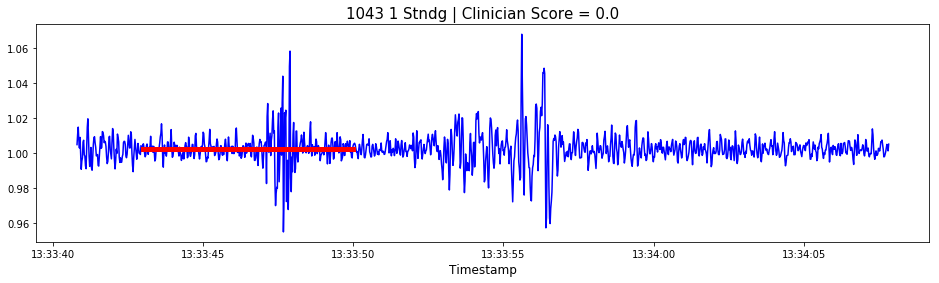

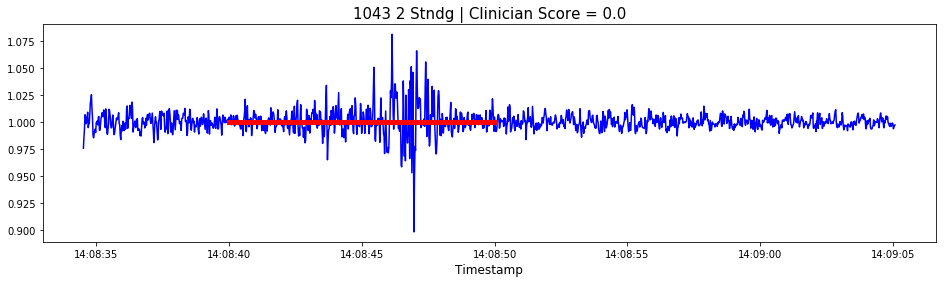

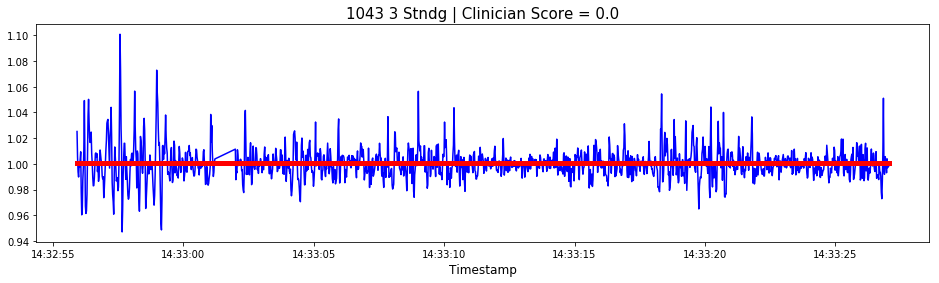

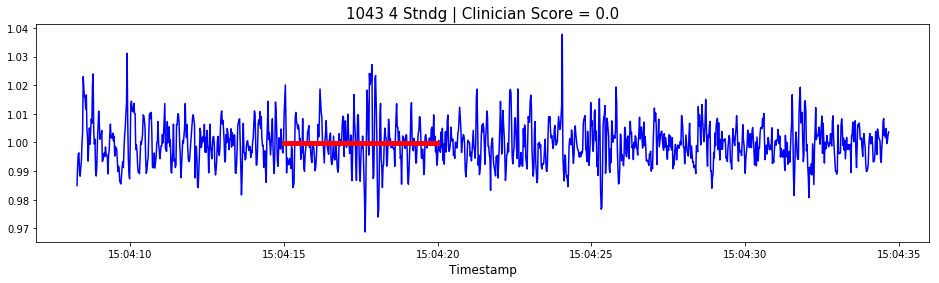

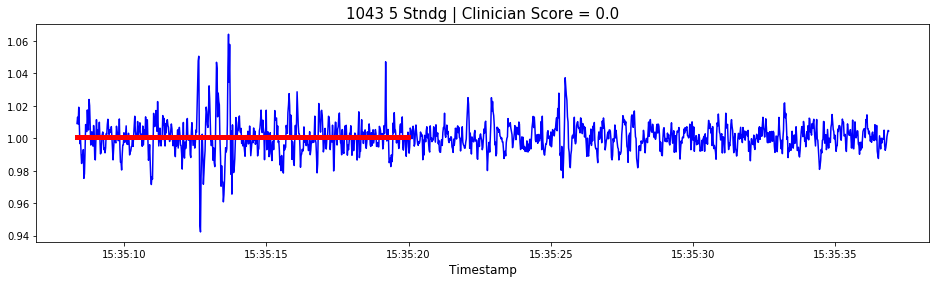

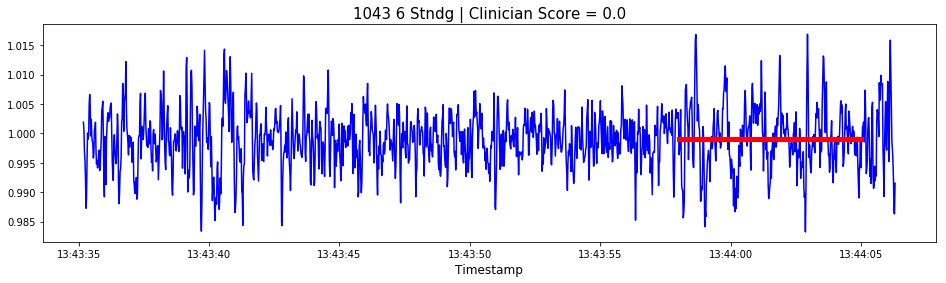

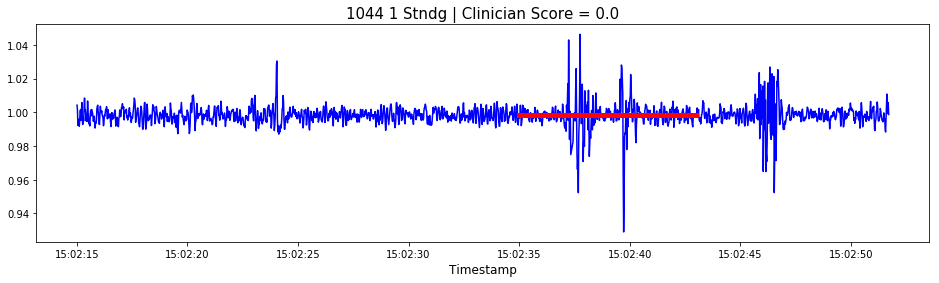

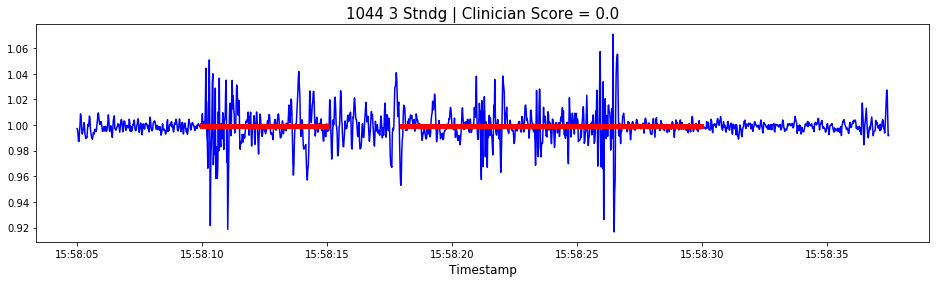

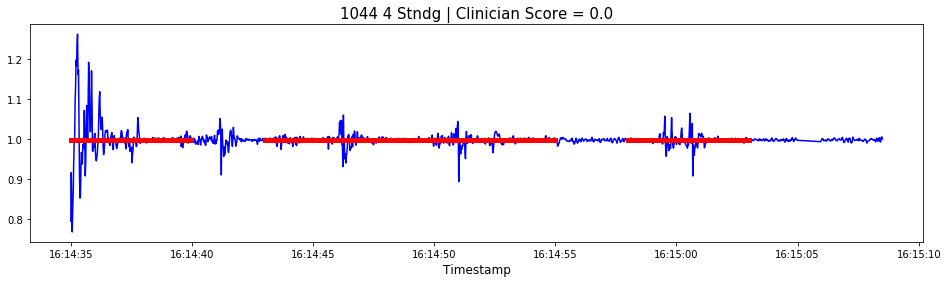

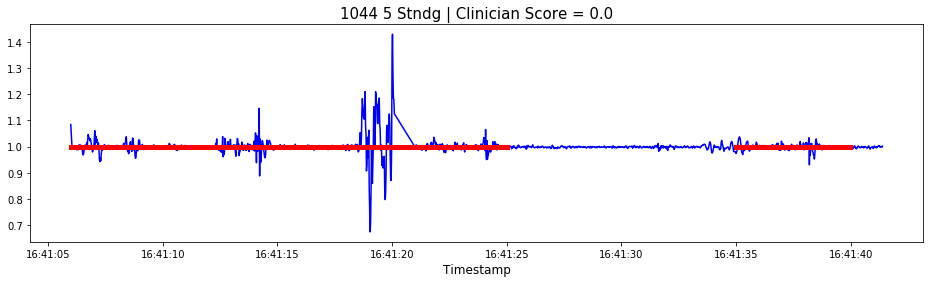

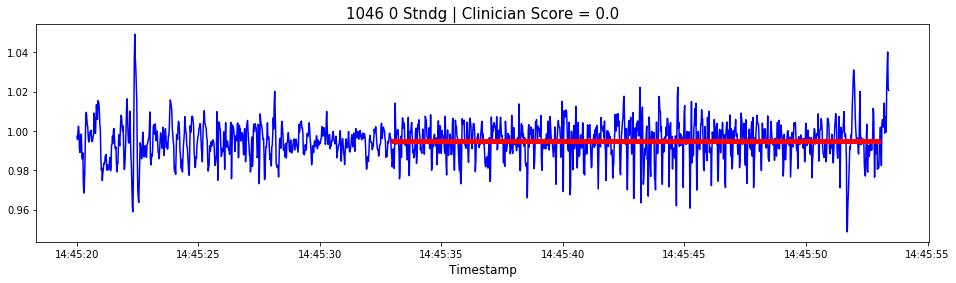

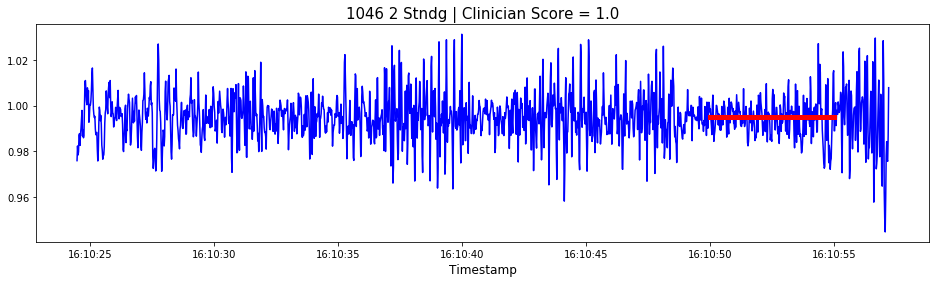

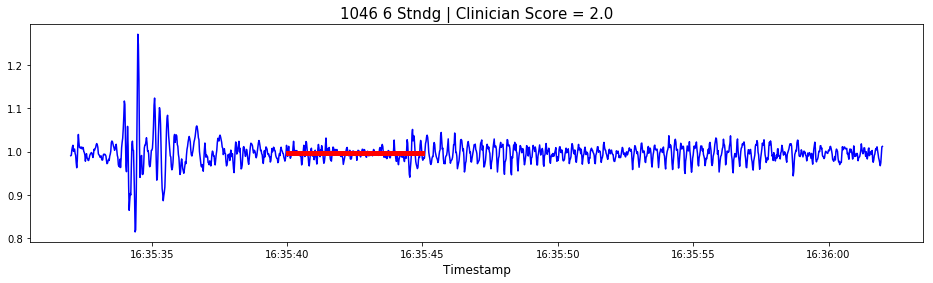

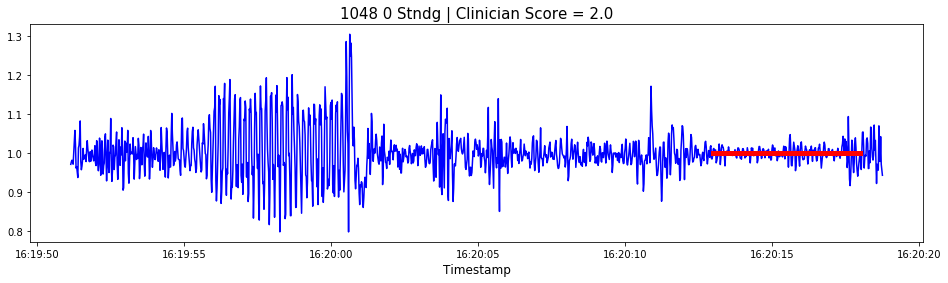

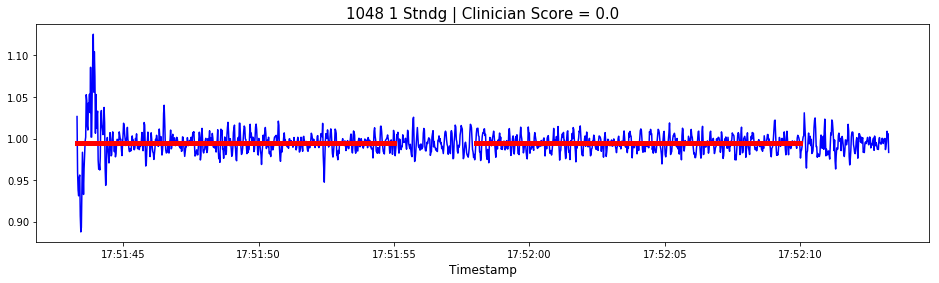

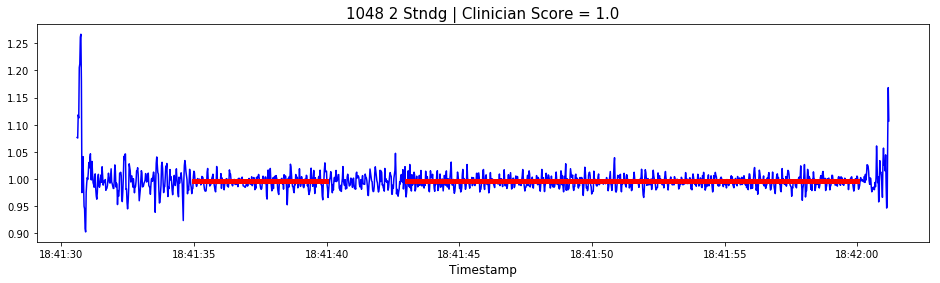

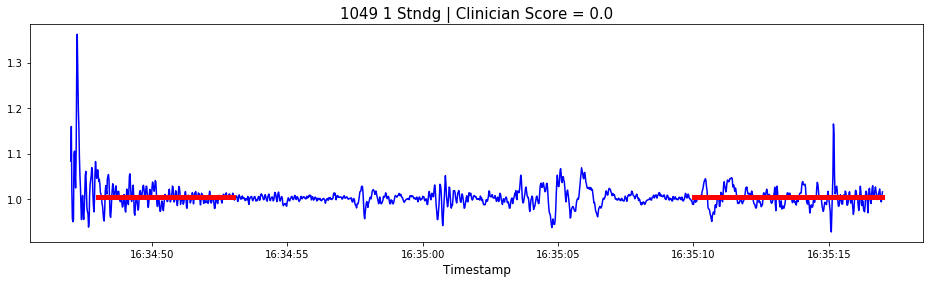

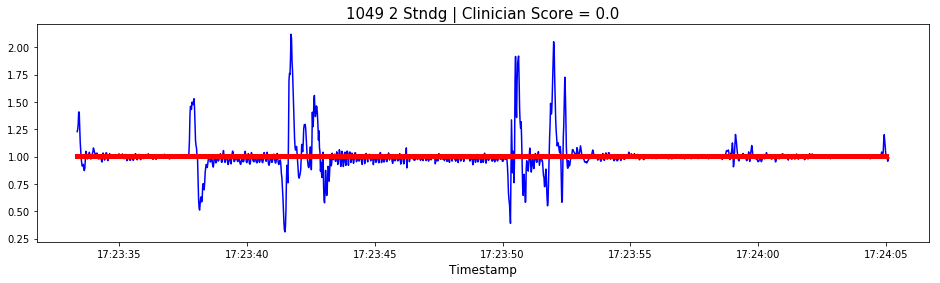

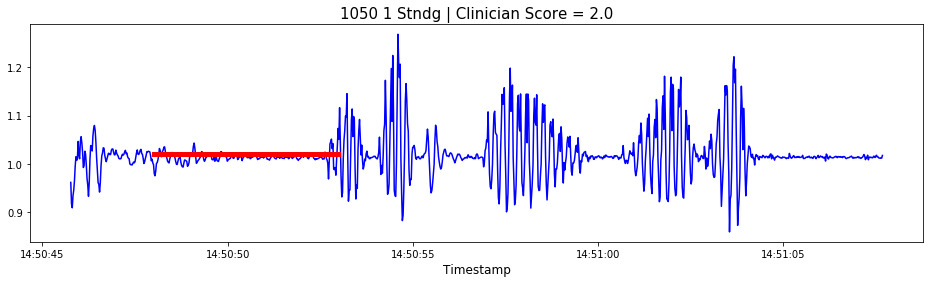

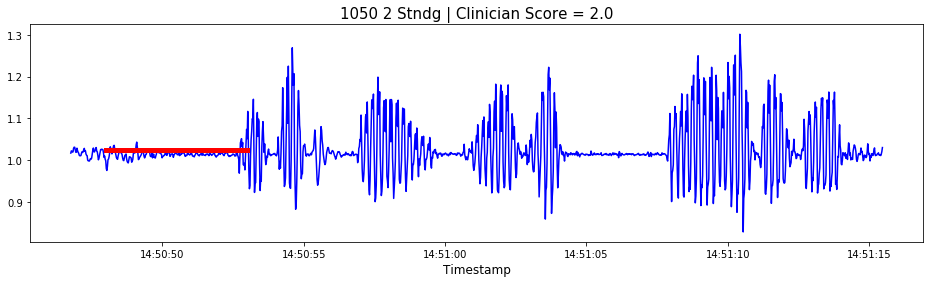

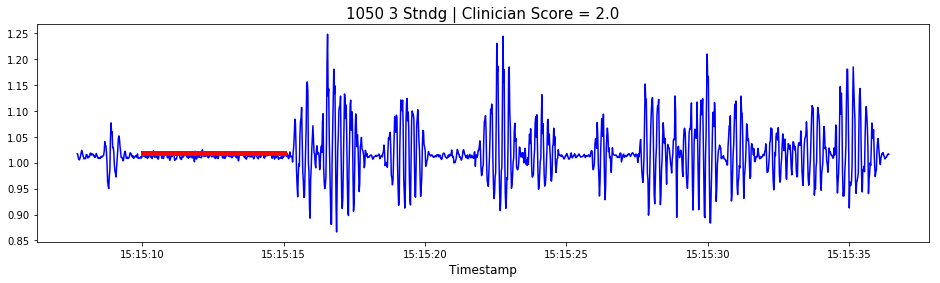

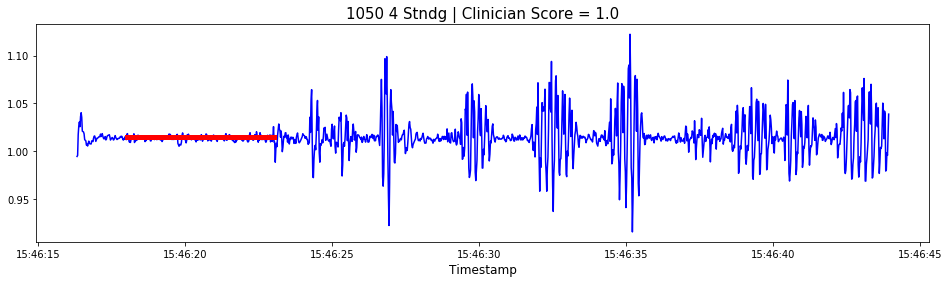

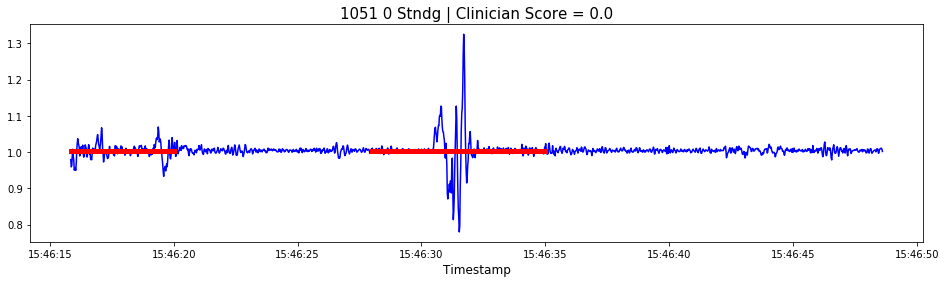

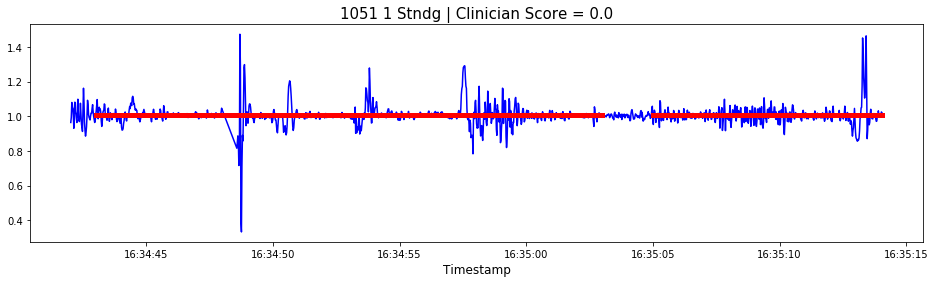

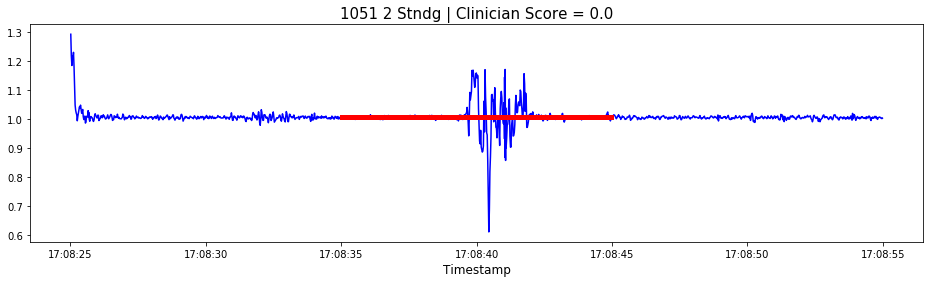

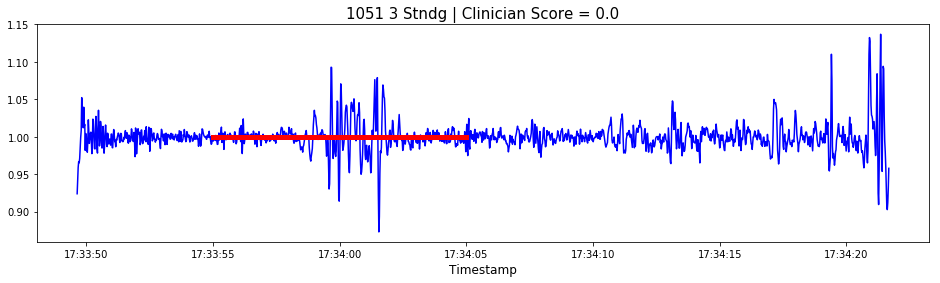

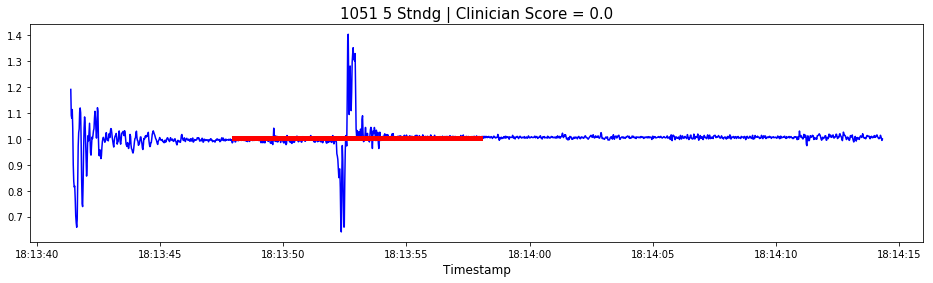

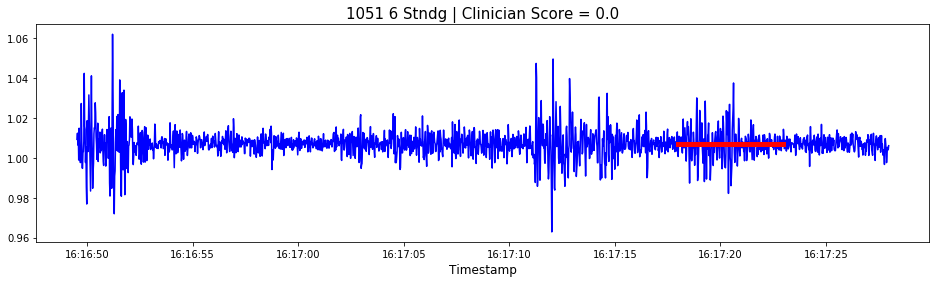

In [98]:
# plot all full task signals containing clips thought to be attached to an improper score for tremor
StndgClipFreq, StndgTaskPred, StndgAUC = scoreTremFFT(ClinicFreqData_max, 'Stndg', '4-8', False)
FalseLabClips = StndgClipFreq[StndgClipFreq.FFTscore != StndgClipFreq.Tremor.apply(lambda x: 1 if x > 0 else x)]
for sub in FalseLabClips.SubjID.unique():
    SFalseLab = FalseLabClips[FalseLabClips.SubjID == sub]
    for visit in SFalseLab.Visit.unique():
        SVFalseLab = SFalseLab[SFalseLab.Visit == visit]
        accdata = pd.read_csv(os.path.join(path, 'TaskAcc', 
                                           str(sub) + '_' + str(visit) + '_' + SVFalseLab.TaskAbb.iloc[-1] + '.csv'), 
                              parse_dates = ['timestamp'])[['timestamp', 'x', 'y', 'z']]
        acc_mag = np.sqrt((accdata.x)**2 + (accdata.y)**2 + (accdata.z)**2)
        SVClips = pd.DataFrame()
        plt.figure(figsize = (16, 4))
        plt.plot(accdata.timestamp, acc_mag, 'b')
        for clip in SVFalseLab.iterrows():
            clipacc = pd.read_csv(os.path.join(dest, 'Clinic Data', 'Feature Clips', 
                                                str(sub) + '_' + str(visit) + '_' + 
                                                clip[1]['TaskAbb'] + '_' + str(clip[1]['Clip']) + '.csv'), 
                                   parse_dates = ['Timestamp'])[['Timestamp']]
            plt.plot(clipacc.values, [np.mean(acc_mag)] * len(clipacc.values), 'r', linewidth = 5)
        plt.xlabel('Timestamp', fontsize = 12)
        plt.title(str(sub) + ' ' + str(visit) + ' ' + SVFalseLab.TaskAbb.iloc[-1] + ' | '
                  'Clinician Score = ' + str(SVFalseLab.Tremor.iloc[-1]), fontsize = 15)
        plt.show()
        
# red line indicates position of 'falsely labeled' clips of the data

In [92]:
clipacc

Timestamp
0   2017-11-01 16:17:18.000
1   2017-11-01 16:17:18.020
2   2017-11-01 16:17:18.040
3   2017-11-01 16:17:18.060
4   2017-11-01 16:17:18.080
5   2017-11-01 16:17:18.100
6   2017-11-01 16:17:18.120
7   2017-11-01 16:17:18.140
8   2017-11-01 16:17:18.160
9   2017-11-01 16:17:18.180
10  2017-11-01 16:17:18.200
11  2017-11-01 16:17:18.220
12  2017-11-01 16:17:18.240
13  2017-11-01 16:17:18.260
14  2017-11-01 16:17:18.280
15  2017-11-01 16:17:18.300
16  2017-11-01 16:17:18.320
17  2017-11-01 16:17:18.341
18  2017-11-01 16:17:18.361
19  2017-11-01 16:17:18.381
20  2017-11-01 16:17:18.401
21  2017-11-01 16:17:18.421
22  2017-11-01 16:17:18.441
23  2017-11-01 16:17:18.461
24  2017-11-01 16:17:18.481
25  2017-11-01 16:17:18.501
26  2017-11-01 16:17:18.521
27  2017-11-01 16:17:18.541
28  2017-11-01 16:17:18.561
29  2017-11-01 16:17:18.581
..                      ...
220 2017-11-01 16:17:22.406
221 2017-11-01 16:17:22.426
222 2017-11-01 16:17:22.446
223 2017-11-01 16:17:22.466
224 2017-11-01 16:17:22.486
225 2017-11-01 16:17:22.506
226 2017-11-01 16:17:22.526
227 2017-11-01 16:17:22.546
228 2017-11-01 16:17:22.566
229 2017-11-01 16:17:22.586
230 2017-11-01 16:17:22.606
231 2017-11-01 16:17:22.626
232 2017-11-01 16:17:22.646
233 2017-11-01 16:17:22.666
234 2017-11-01 16:17:22.686
235 2017-11-01 16:17:22.706
236 2017-11-01 16:17:22.726
237 2017-11-01 16:17:22.746
238 2017-11-01 16:17:22.766
239 2017-11-01 16:17:22.786
240 2017-11-01 16:17:22.806
241 2017-11-01 16:17:22.826
242 2017-11-01 16:17:22.846
243 2017-11-01 16:17:22.866
244 2017-11-01 16:17:22.886
245 2017-11-01 16:17:22.906
246 2017-11-01 16:17:22.926
247 2017-11-01 16:17:22.947
248 2017-11-01 16:17:22.967
249 2017-11-01 16:17:22.987

[250 rows x 1 columns]

In [79]:
# determine performance using the different frequency ranges via AUC - Sitting
FreqRange = []
AUC = []
for freq in ClinicFreqData_max.columns[8:]:
    SitngClipFreq, SitngTaskPred, SitngAUC = scoreTremFFT(ClinicFreqData_mean, 'Sitng', freq, False)
    FreqRange = FreqRange + [freq]
    AUC = AUC + [SitngAUC]
pd.DataFrame({'FreqRange': FreqRange, 'AUC': AUC})

FreqRange       AUC
0        0-2  0.786137
1        2-4  0.773832
2        4-6  0.784579
3        4-8  0.799533
4        6-8  0.814330
5       8-10  0.808411
6      10-12  0.822430
7      12-14  0.825545
8      14-16  0.810903
9      16-18  0.811059
10     18-20  0.862150

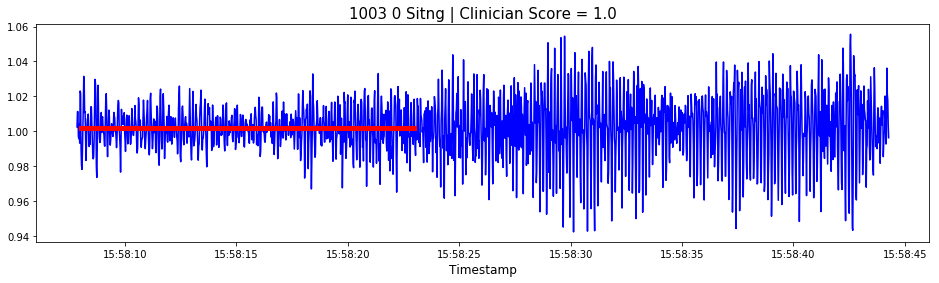

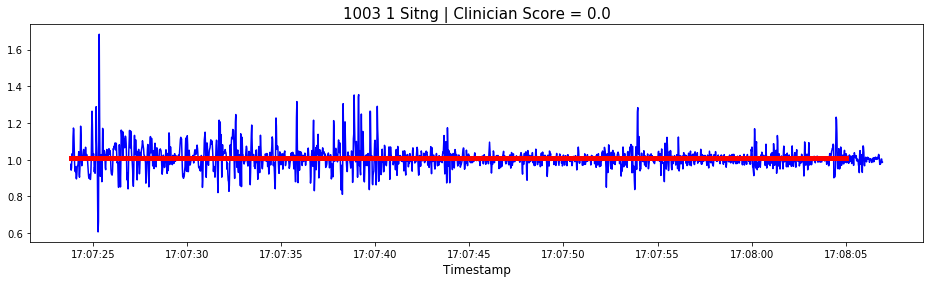

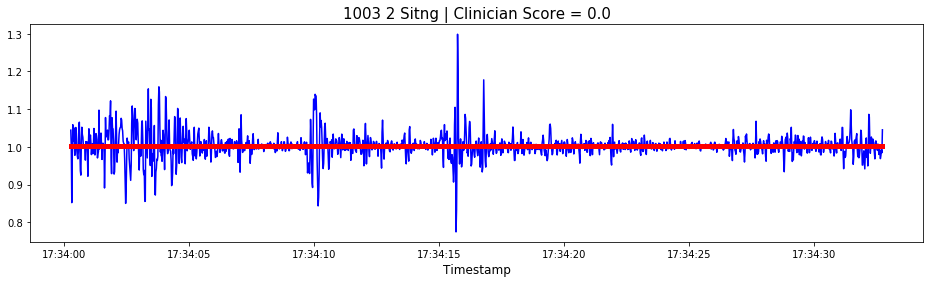

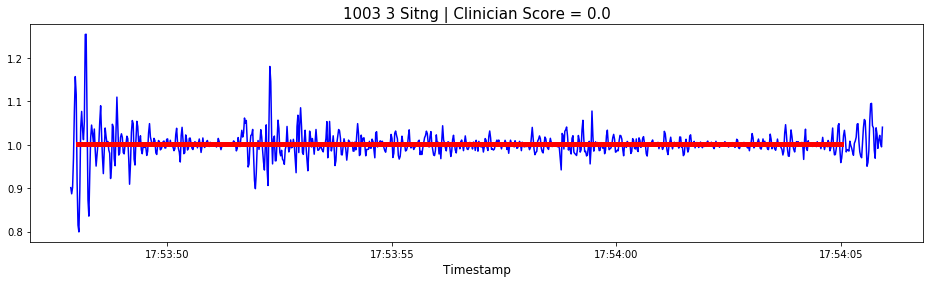

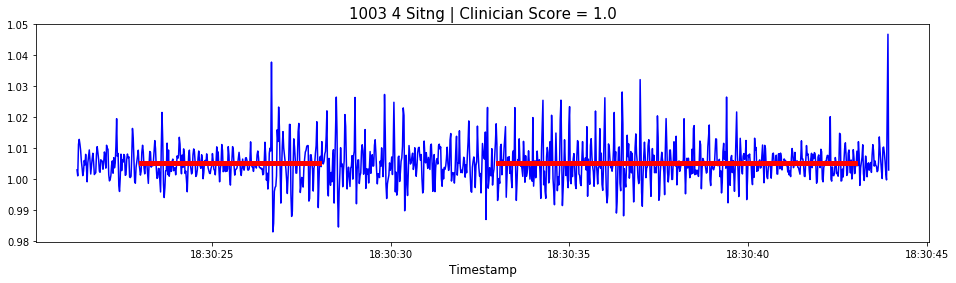

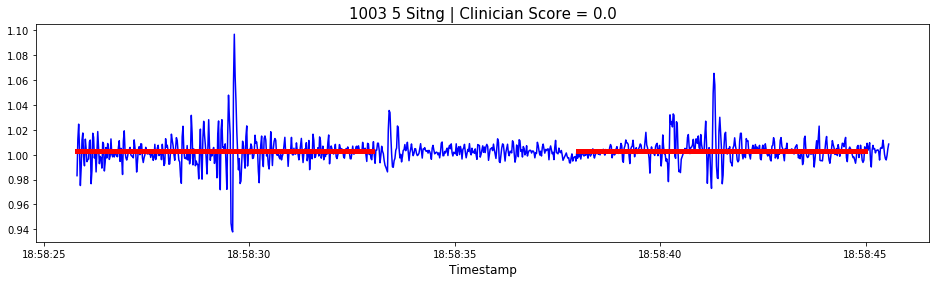

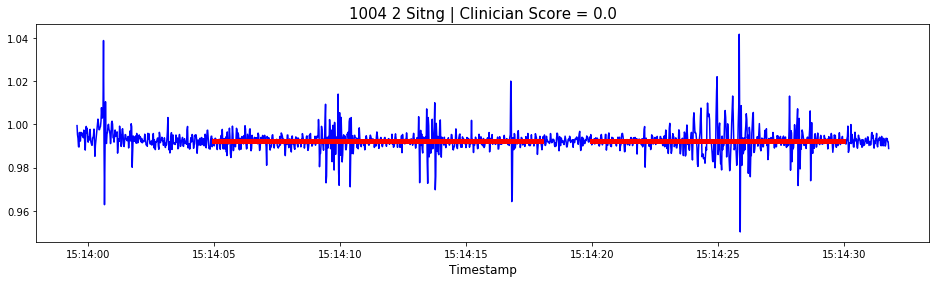

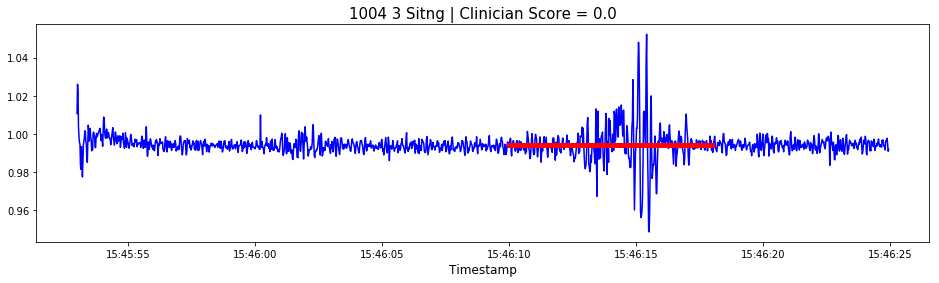

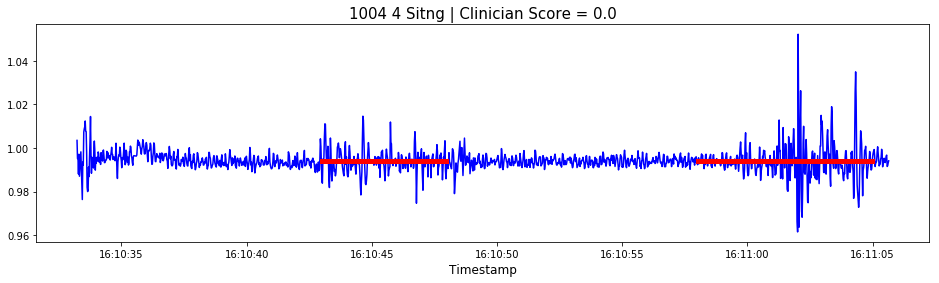

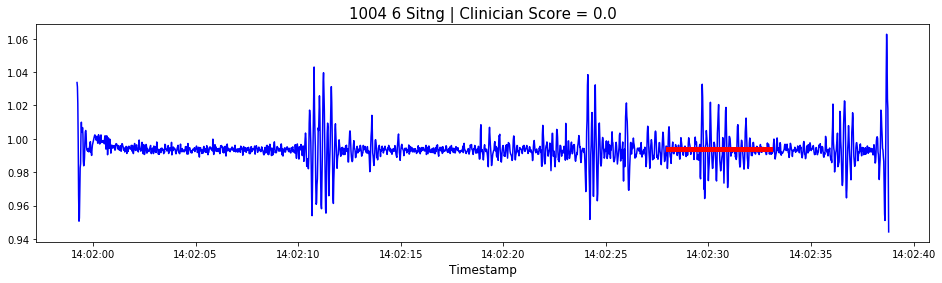

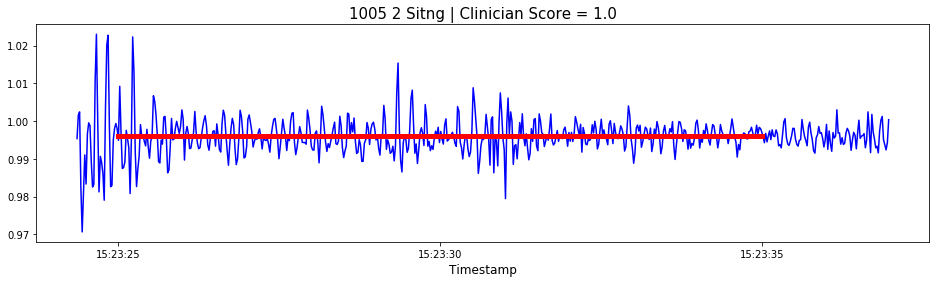

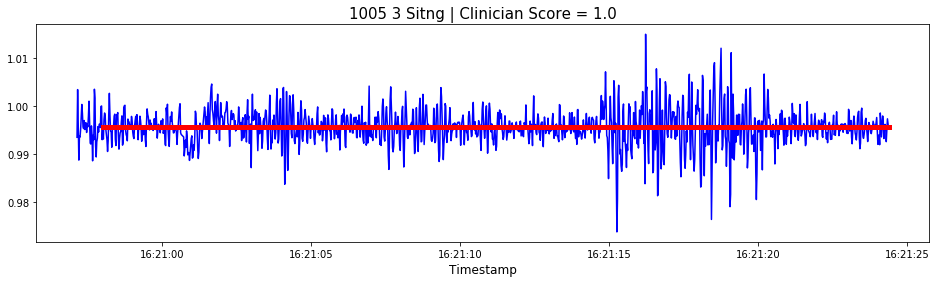

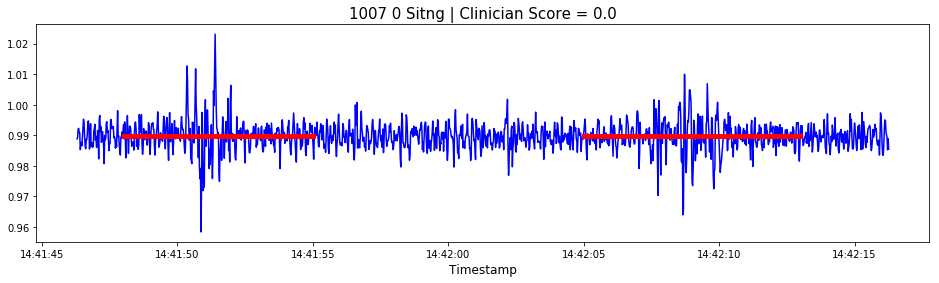

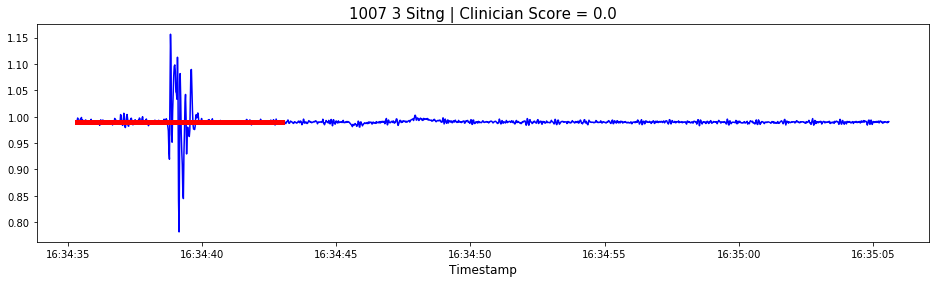

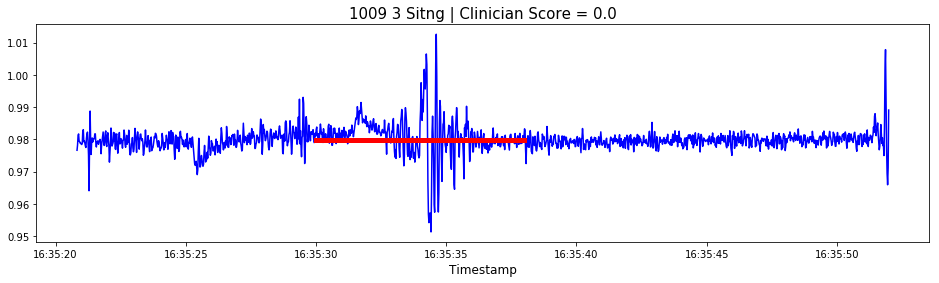

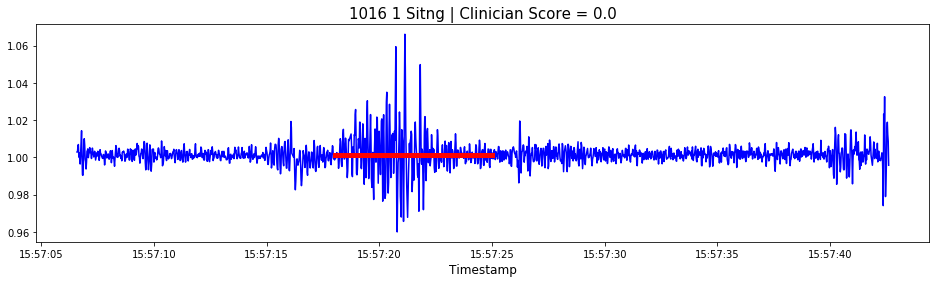

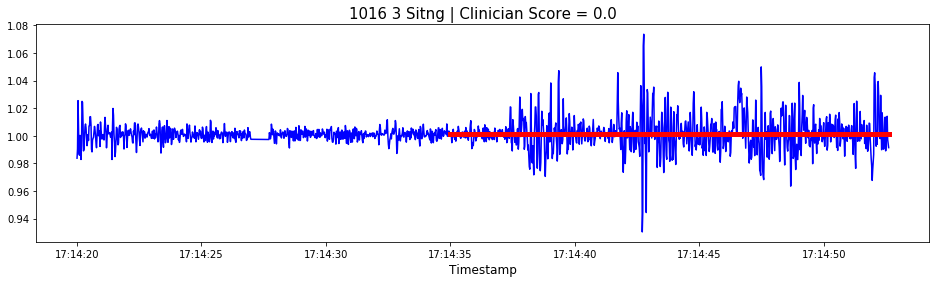

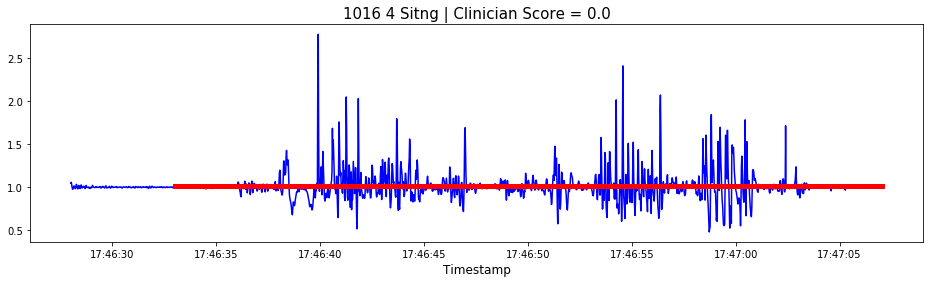

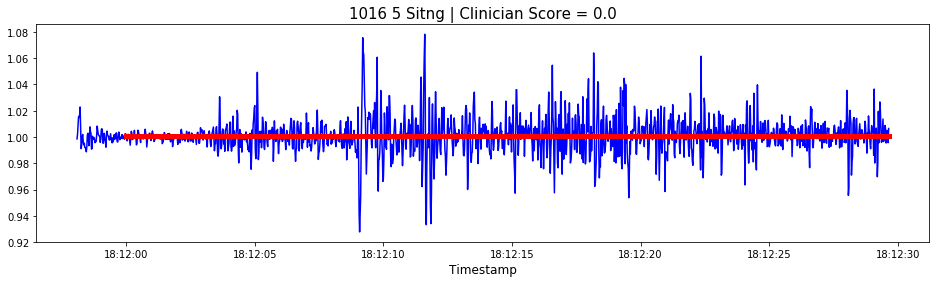

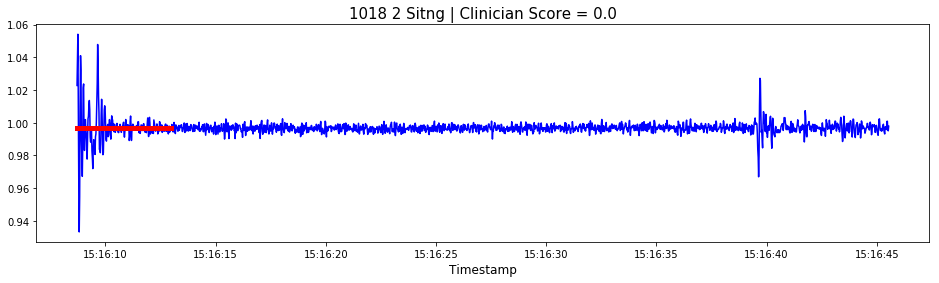

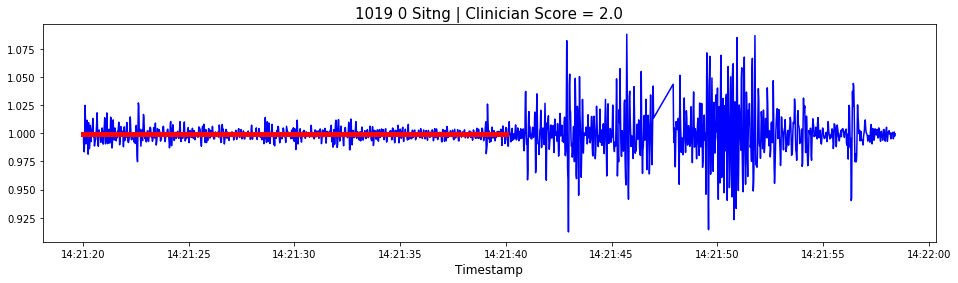

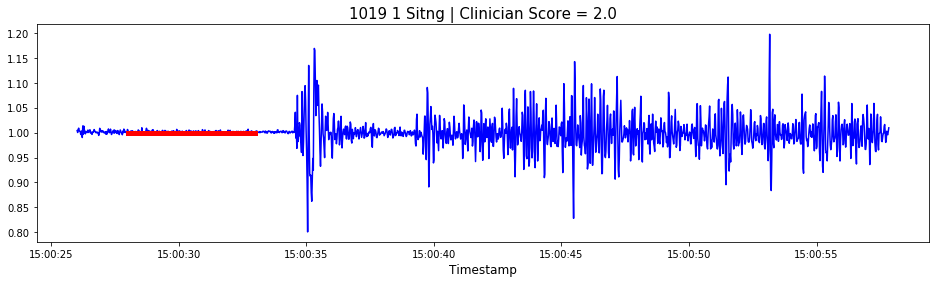

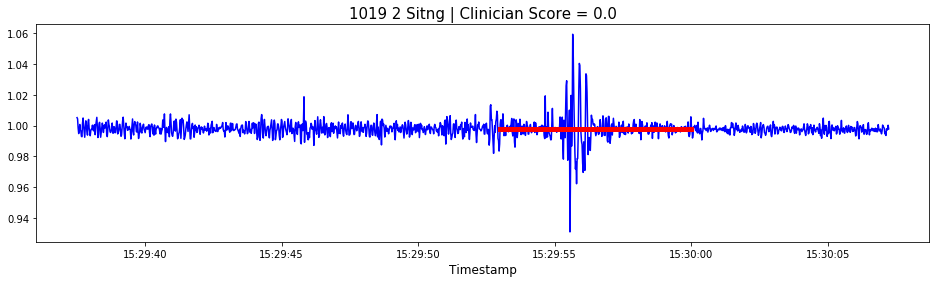

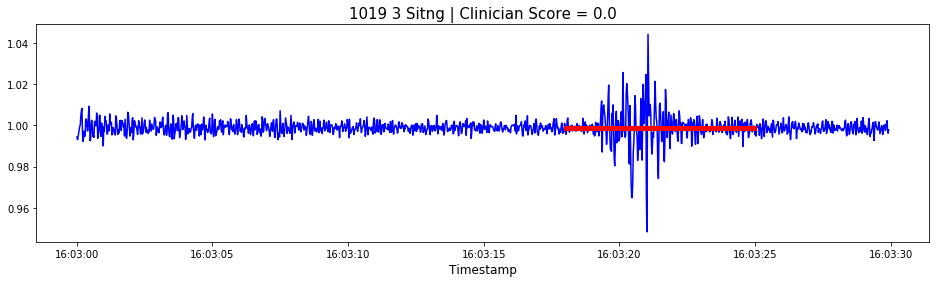

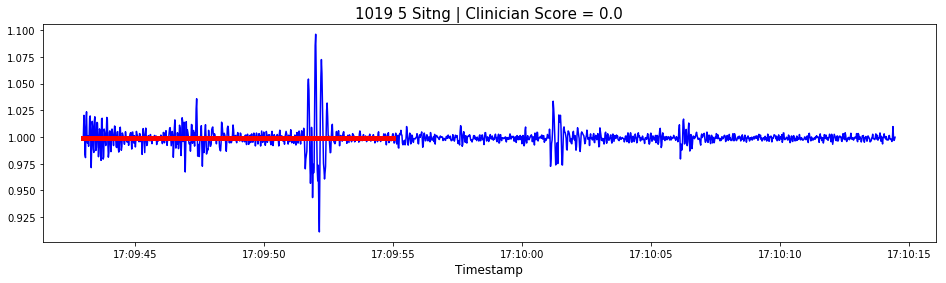

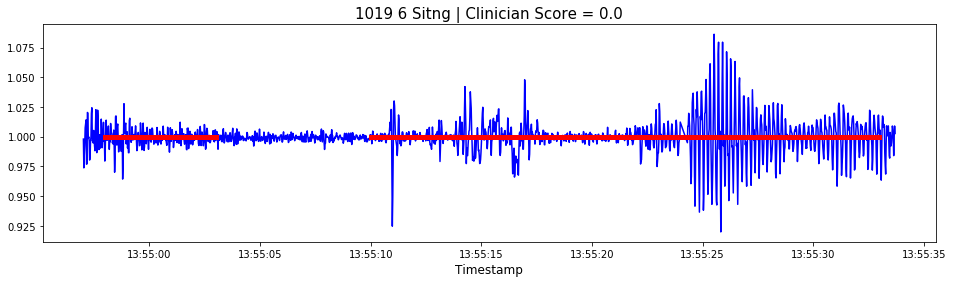

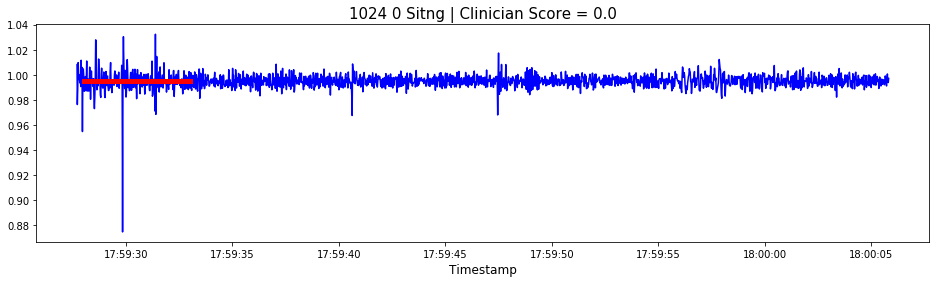

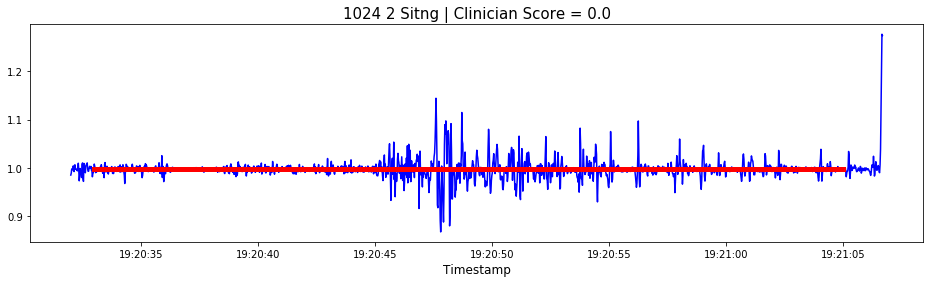

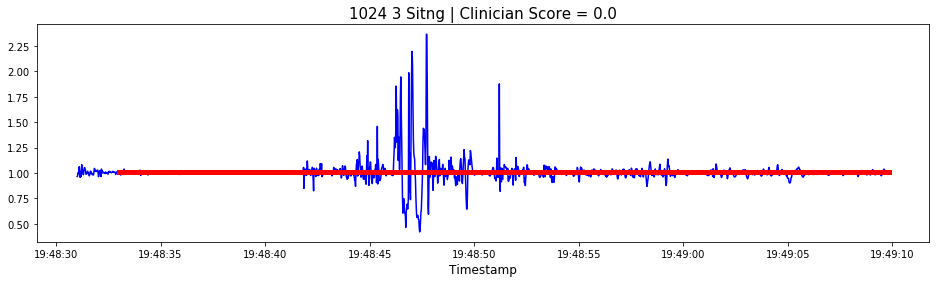

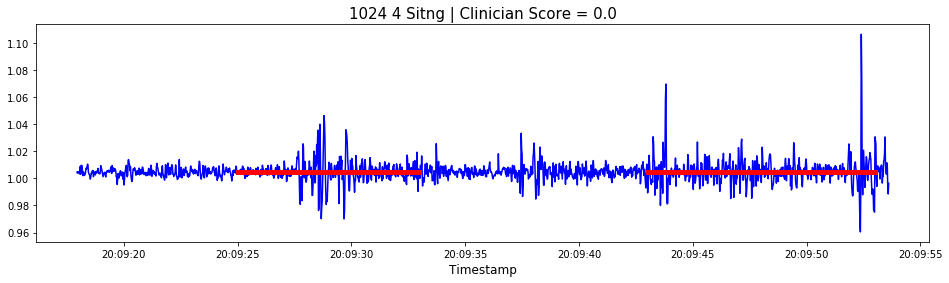

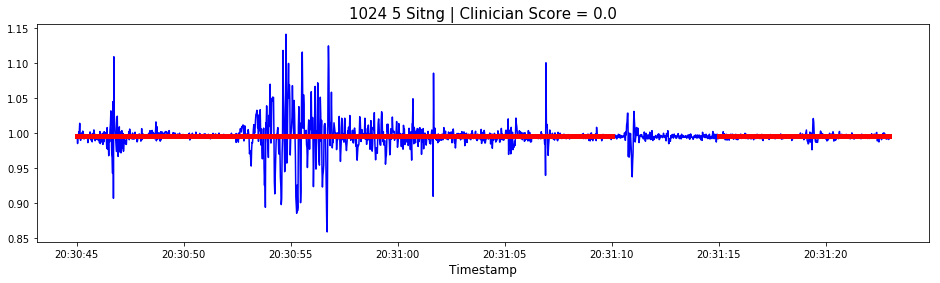

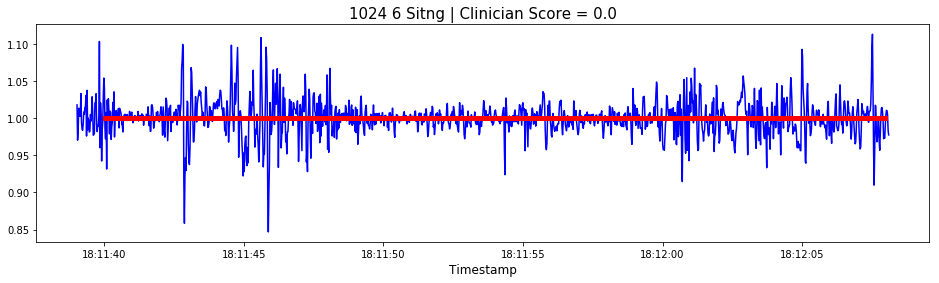

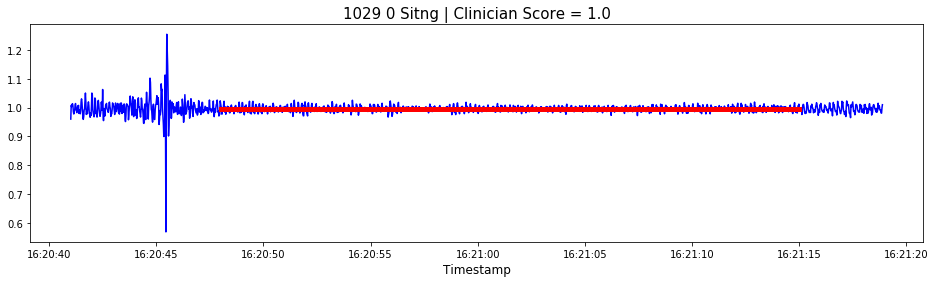

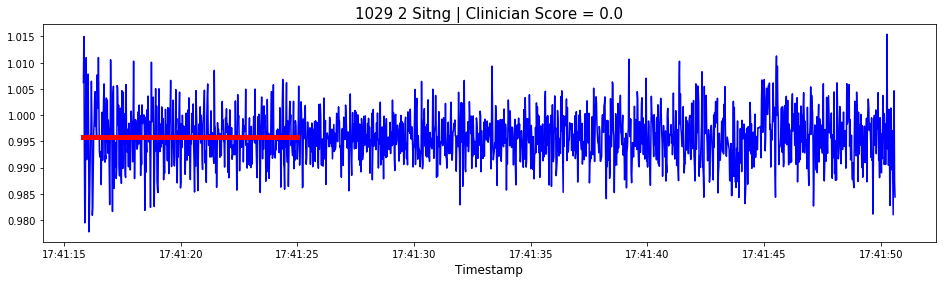

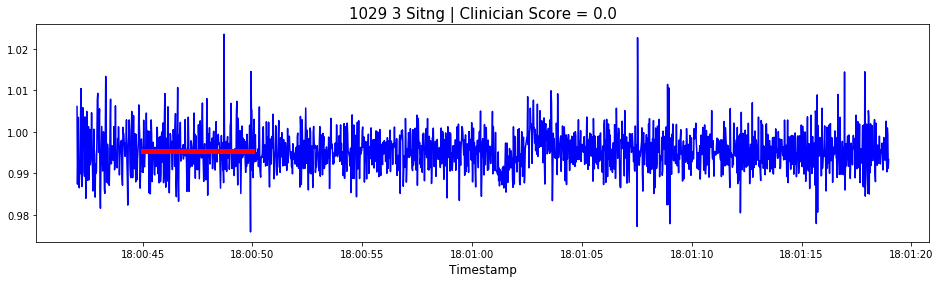

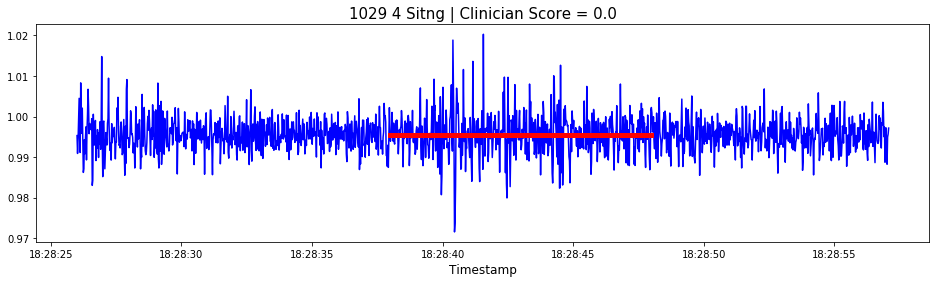

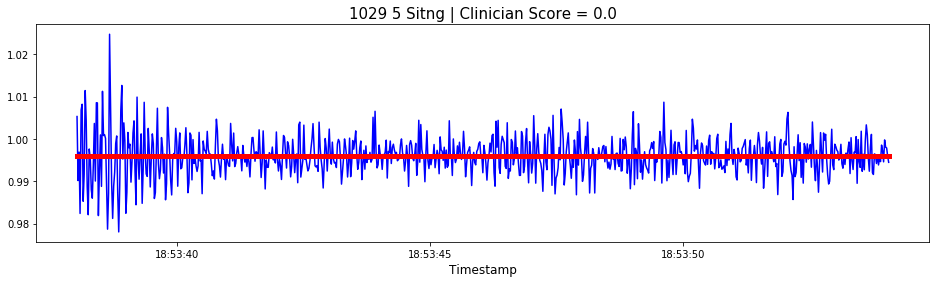

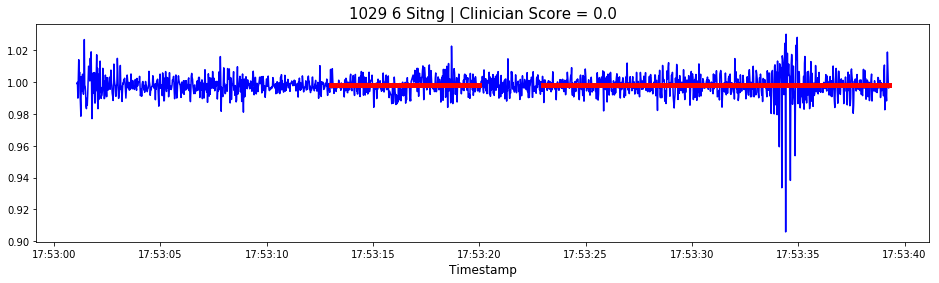

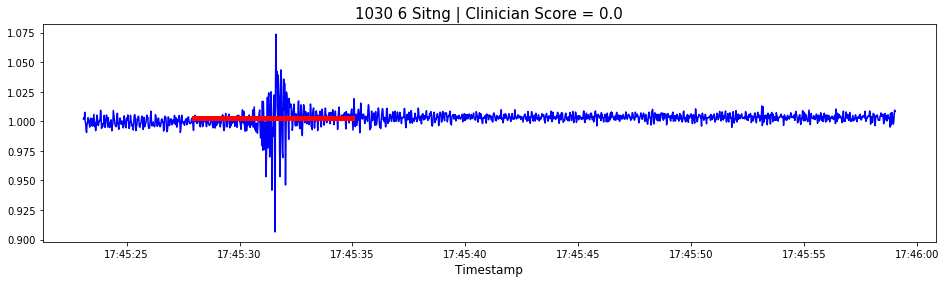

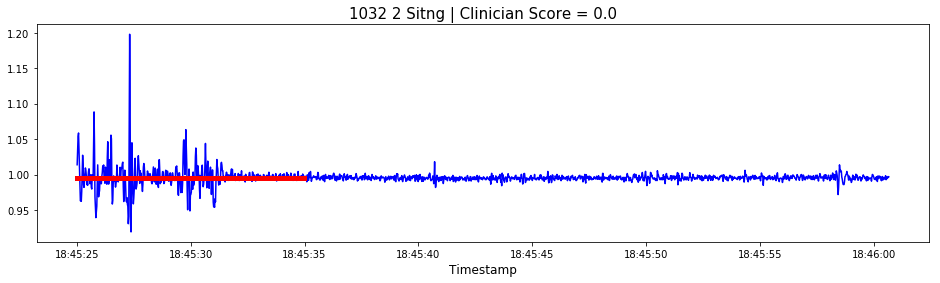

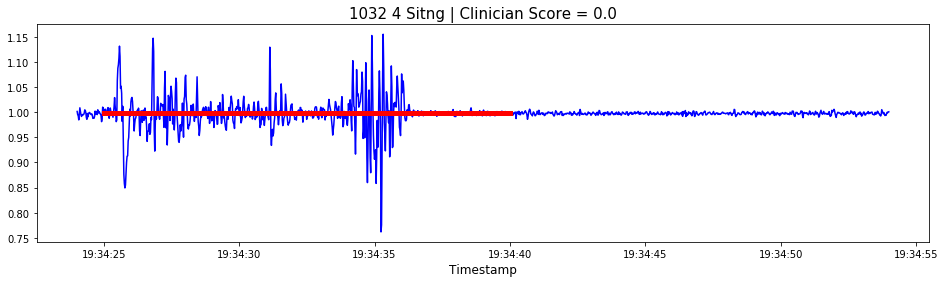

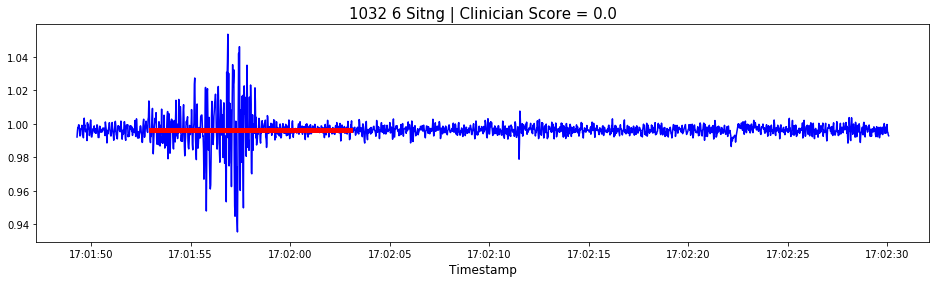

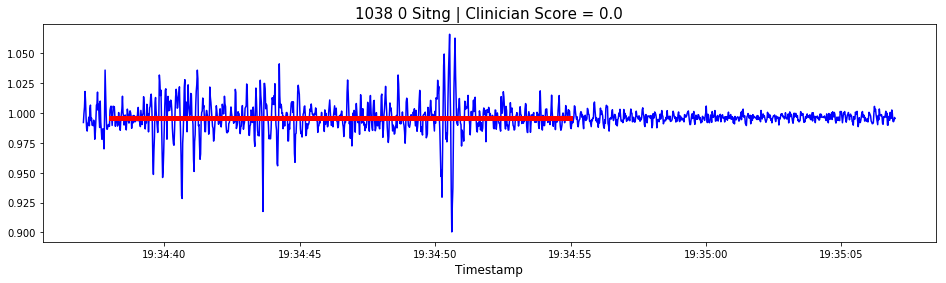

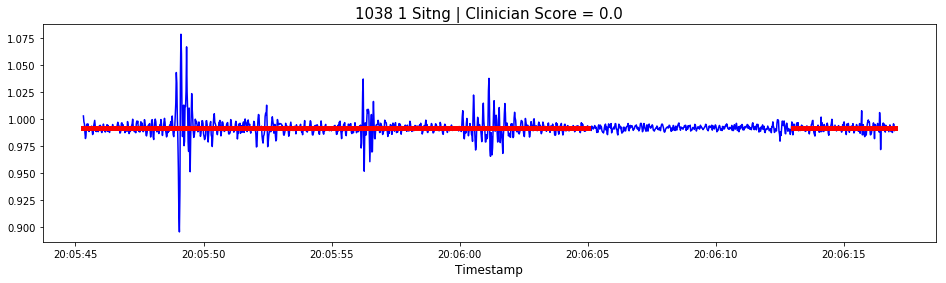

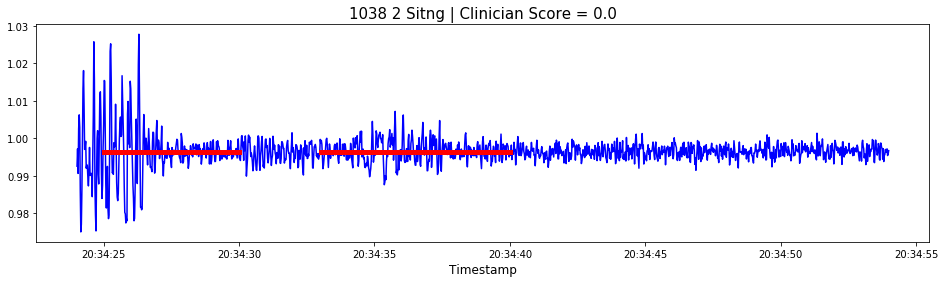

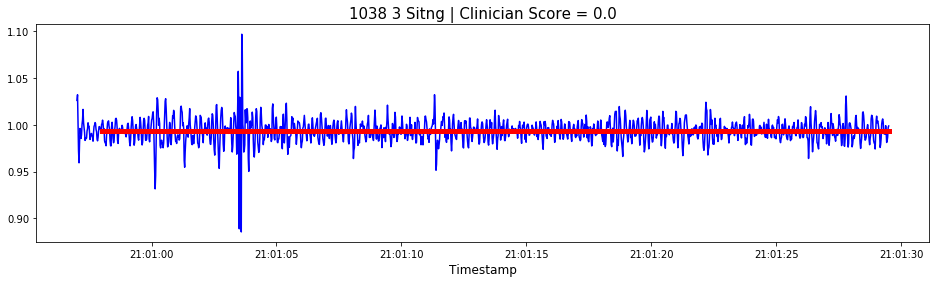

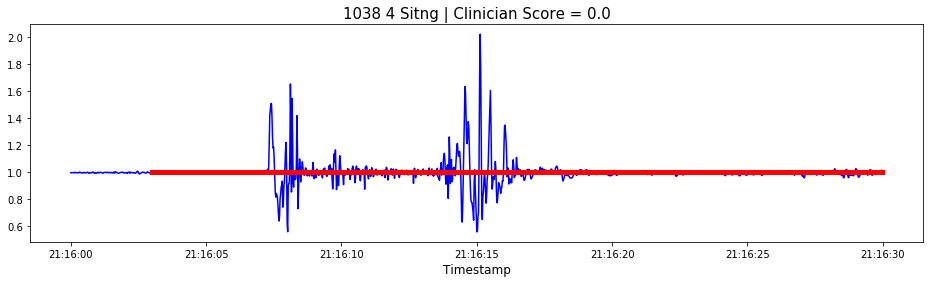

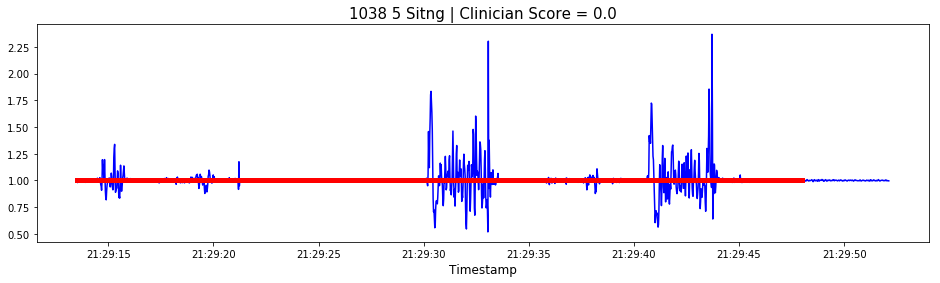

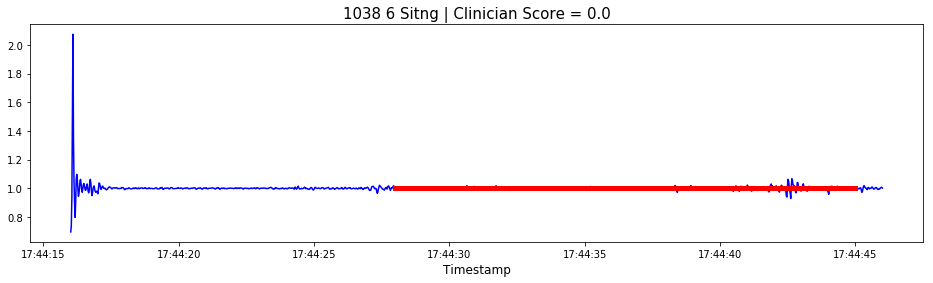

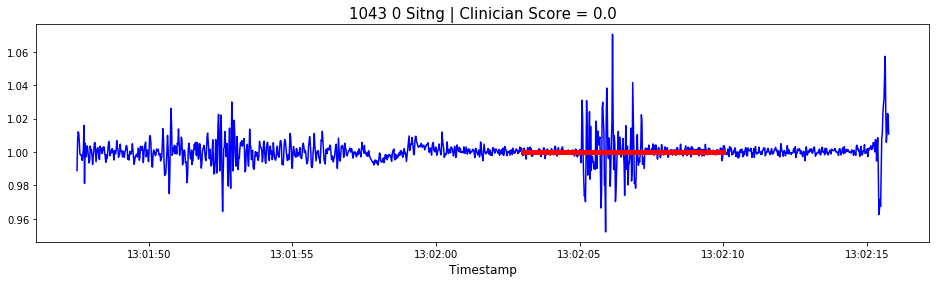

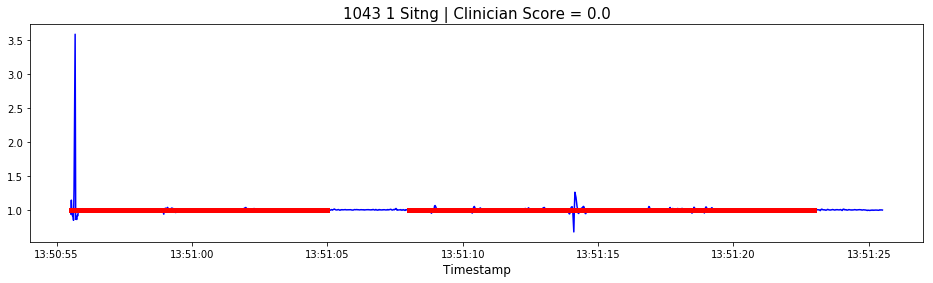

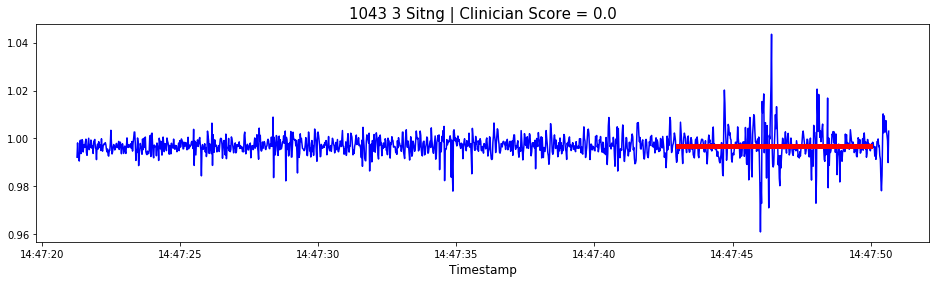

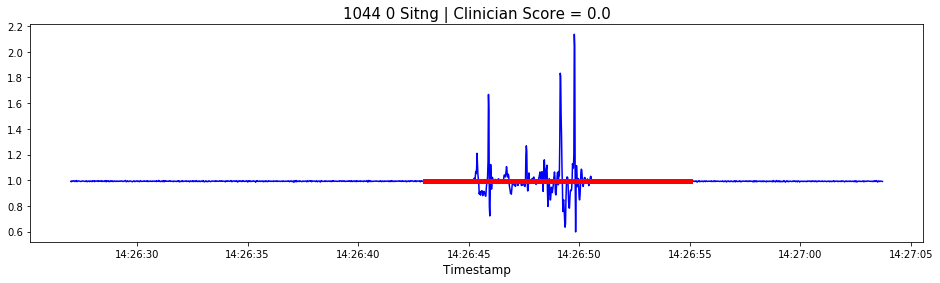

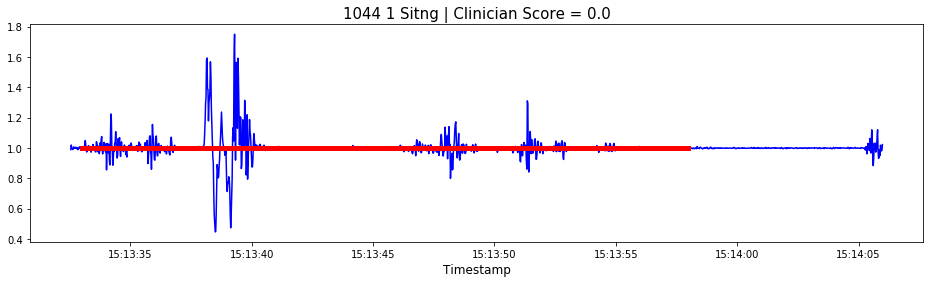

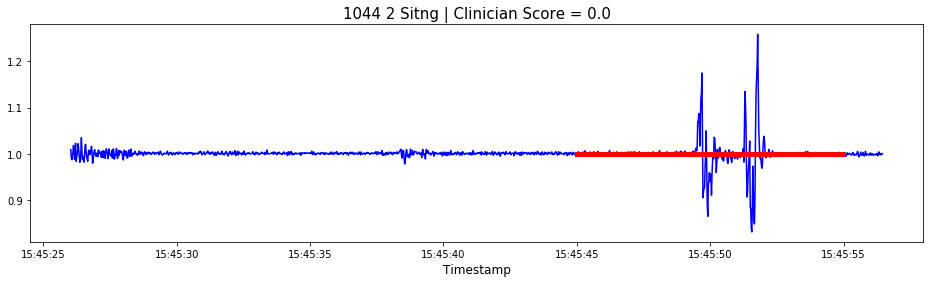

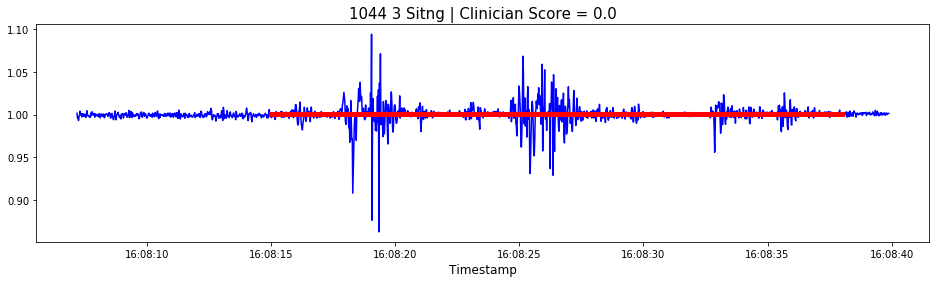

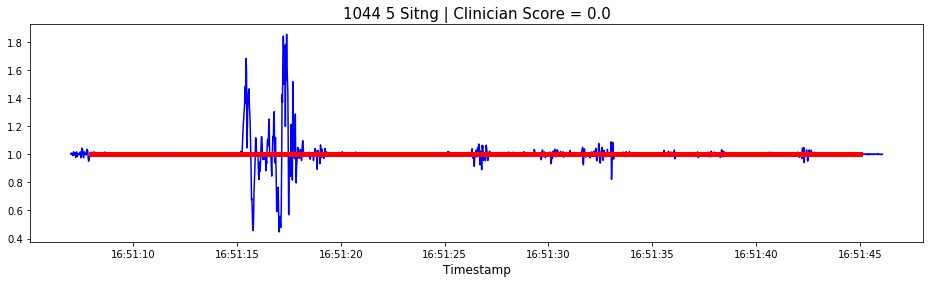

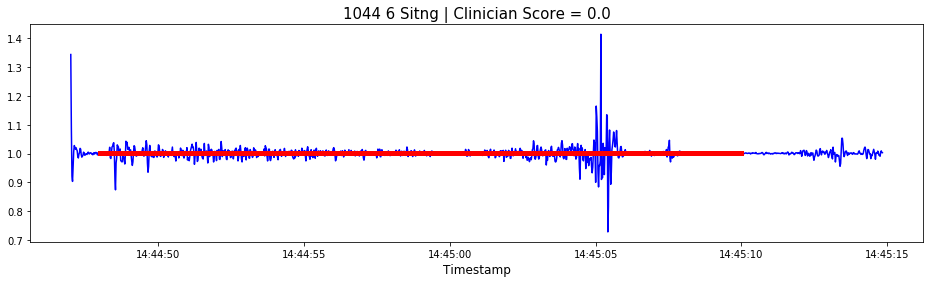

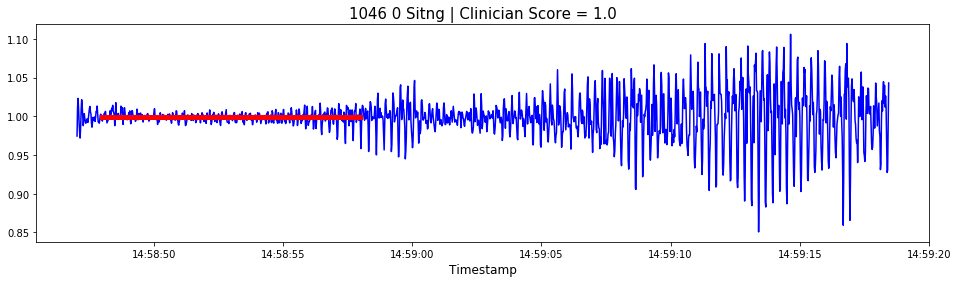

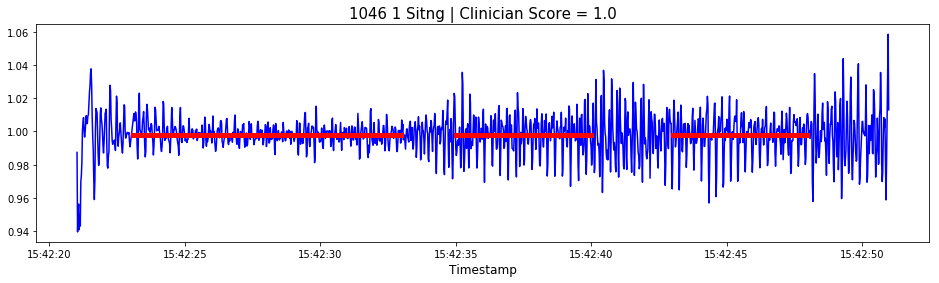

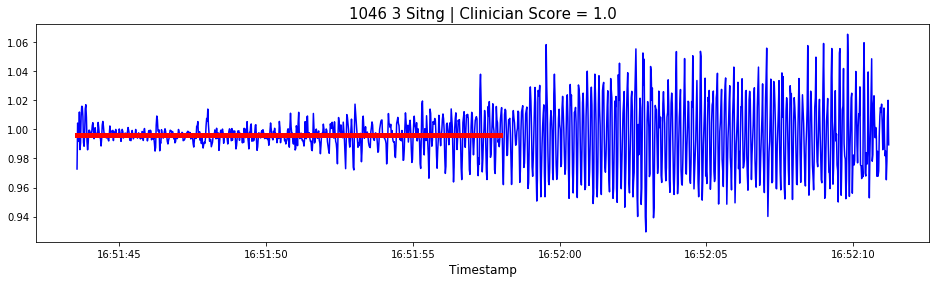

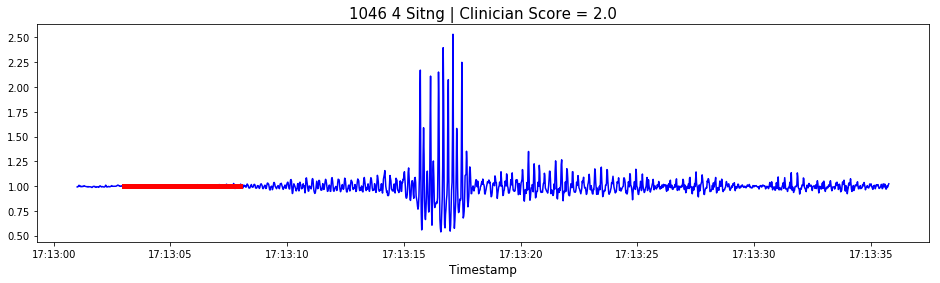

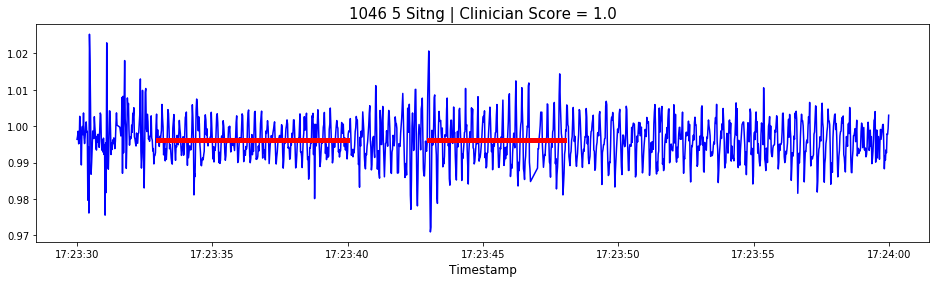

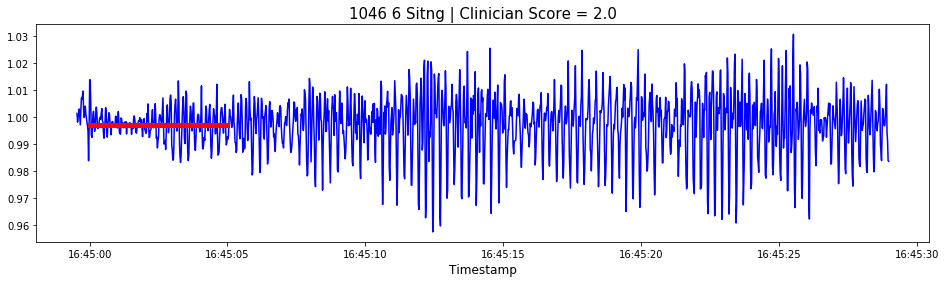

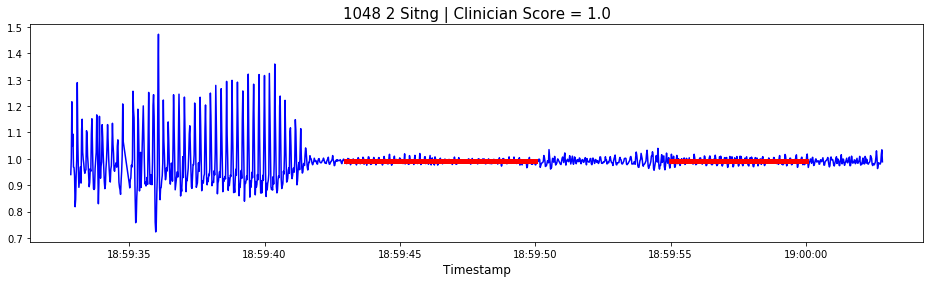

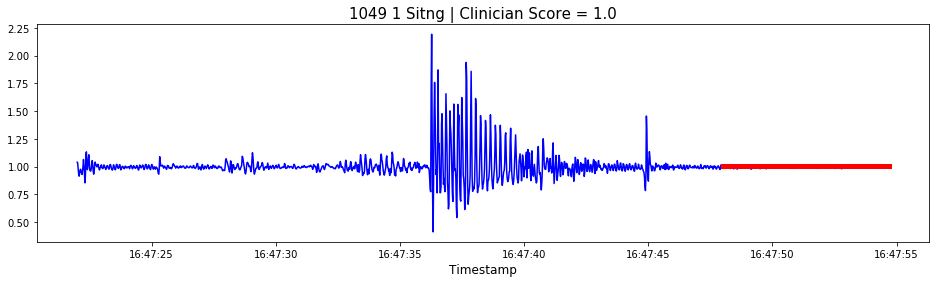

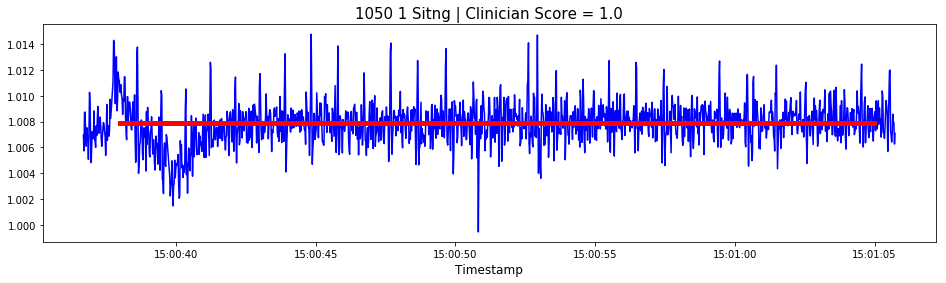

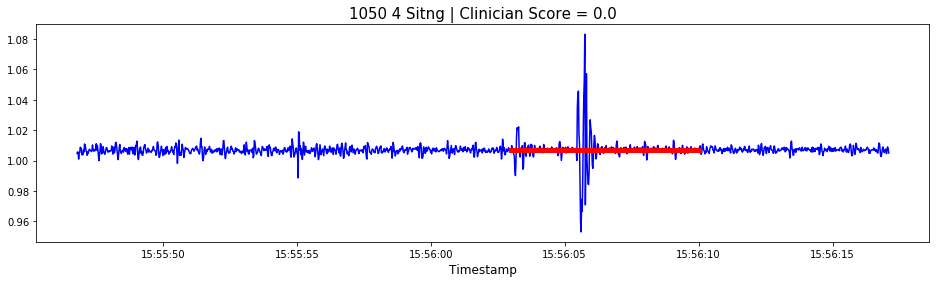

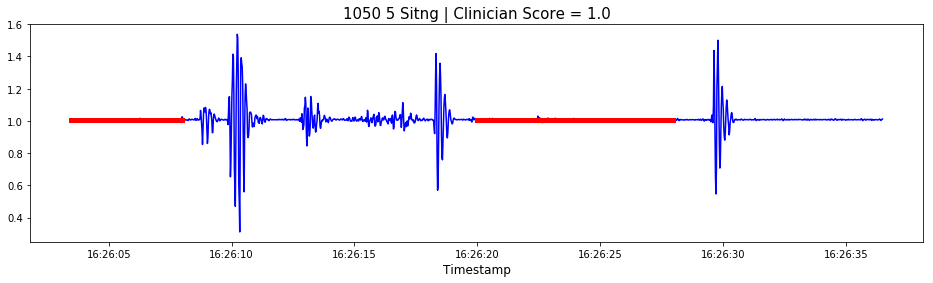

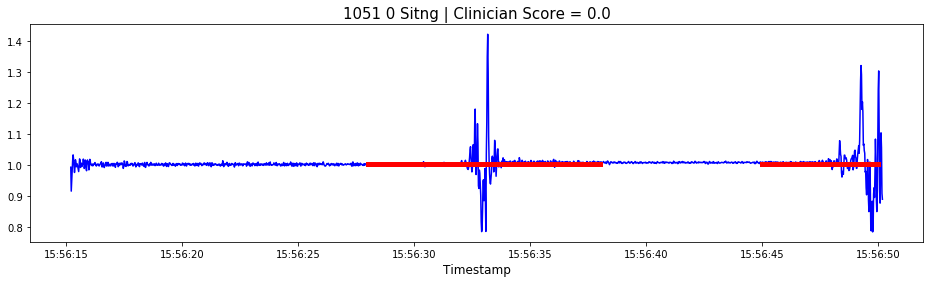

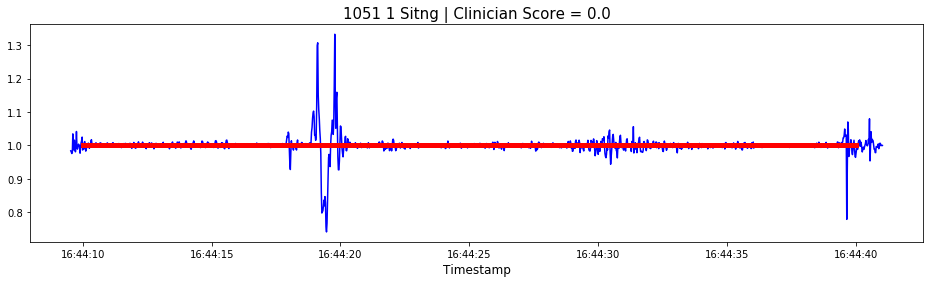

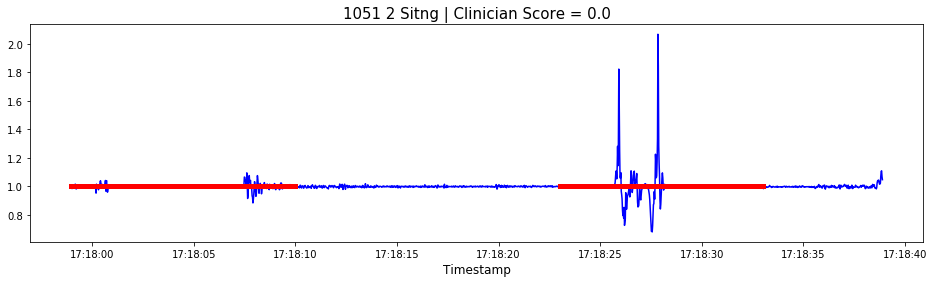

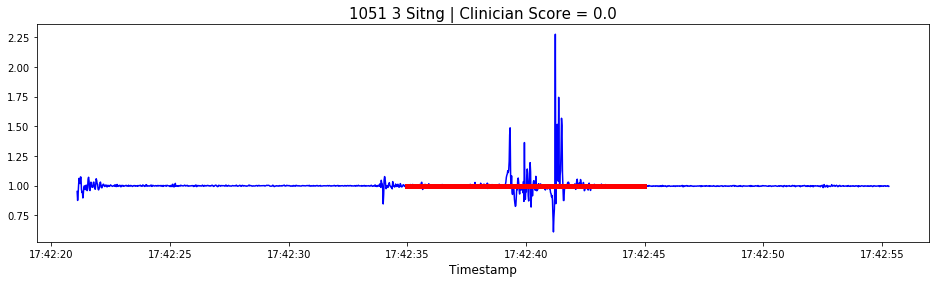

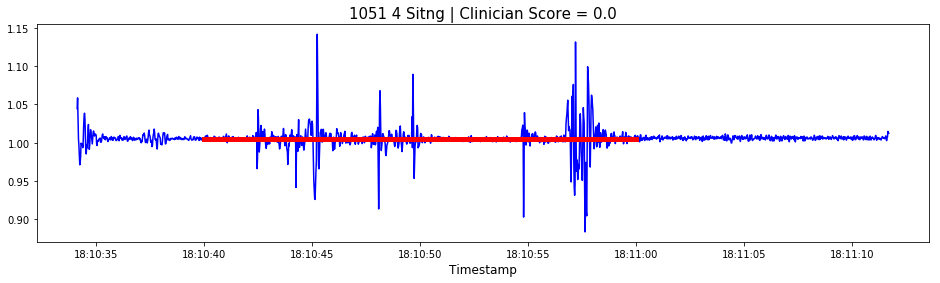

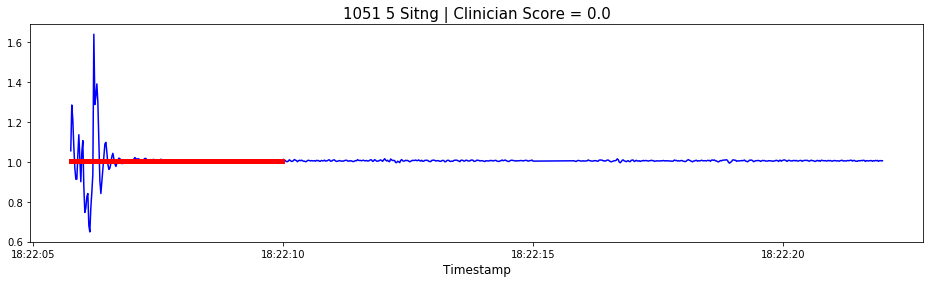

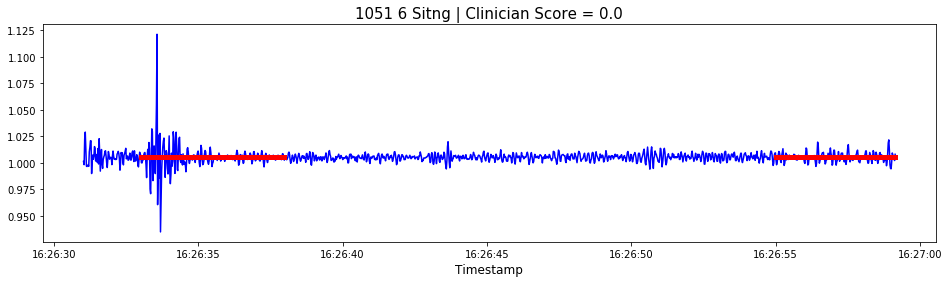

In [99]:
# plot all full task signals containing clips thought to be attached to an improper score for tremor
SitngClipFreq, SitngTaskPred, SitngAUC = scoreTremFFT(ClinicFreqData_max, 'Sitng', '4-8', False)
FalseLabClips = SitngClipFreq[SitngClipFreq.FFTscore != SitngClipFreq.Tremor.apply(lambda x: 1 if x > 0 else x)]
for sub in FalseLabClips.SubjID.unique():
    SFalseLab = FalseLabClips[FalseLabClips.SubjID == sub]
    for visit in SFalseLab.Visit.unique():
        SVFalseLab = SFalseLab[SFalseLab.Visit == visit]
        accdata = pd.read_csv(os.path.join(path, 'TaskAcc', 
                                           str(sub) + '_' + str(visit) + '_' + SVFalseLab.TaskAbb.iloc[-1] + '.csv'), 
                              parse_dates = ['timestamp'])[['timestamp', 'x', 'y', 'z']]
        acc_mag = np.sqrt((accdata.x)**2 + (accdata.y)**2 + (accdata.z)**2)
        SVClips = pd.DataFrame()
        plt.figure(figsize = (16, 4))
        plt.plot(accdata.timestamp, acc_mag, 'b')
        for clip in SVFalseLab.iterrows():
            clipacc = pd.read_csv(os.path.join(dest, 'Clinic Data', 'Feature Clips', 
                                                str(sub) + '_' + str(visit) + '_' + 
                                                clip[1]['TaskAbb'] + '_' + str(clip[1]['Clip']) + '.csv'), 
                                   parse_dates = ['Timestamp'])[['Timestamp']]
            plt.plot(clipacc.values, [np.mean(acc_mag)] * len(clipacc.values), 'r', linewidth = 5)
        plt.xlabel('Timestamp', fontsize = 12)
        plt.title(str(sub) + ' ' + str(visit) + ' ' + SVFalseLab.TaskAbb.iloc[-1] + ' | '
                  'Clinician Score = ' + str(SVFalseLab.Tremor.iloc[-1]), fontsize = 15)
        plt.show()
        
# red line indicates position of 'falsely labeled' clips of the data